In [1]:
import glob
import os
import json

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import cPickle as pkl


from pipeline.python.classifications import experiment_classes as util


import scipy.stats as spstats

from pipeline.python.utils import label_figure, natural_keys
from pipeline.python.classifications import bootstrap_fit_tuning_curves as osi
from pipeline.python.classifications import get_dataset_stats as gd

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
   

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/get_traces.py:96: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  Fi

In [2]:
from scipy.spatial.distance import pdist, squareform


from sklearn.linear_model import LinearRegression
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

def fit_linear_regr(xvals, yvals, return_regr=False):
    regr = LinearRegression()
    if len(xvals.shape) == 1:
        xvals = np.array(xvals).reshape(-1, 1)
        yvals = np.array(yvals).reshape(-1, 1)
    else:
        xvals = np.array(xvals)
        yvals = np.array(yvals)
    regr.fit(xvals, yvals)
    fitv = regr.predict(xvals)
    if return_regr:
        return fitv.reshape(-1), regr
    else:
        return fitv.reshape(-1)


In [3]:
from itertools import combinations

def unpack_square_matrix(corrmat, name='corrcoef', return_combos=True):
    n_list = np.arange(0, corrmat.shape[0])
    
    dataCorr = corrmat.copy()
    dataCorr = dataCorr.stack().reset_index()
    dataCorr = dataCorr[dataCorr['level_0'] != dataCorr['level_1']]

    # filtering out lower/upper triangular duplicates 
    dataCorr['ordered-cols'] = dataCorr.apply(lambda x: '-'.join( [str(i) for i in sorted([x['level_0'],x['level_1']])] ),axis=1)
    dataCorr = dataCorr.drop_duplicates(['ordered-cols'])
    dataCorr.drop(['ordered-cols'], axis=1, inplace=True)
    dataCorr[name] = dataCorr[0].copy()
    dataCorr.drop([0], axis=1, inplace=True)

    n_expected=len([",".join(map(str, comb)) for comb in combinations(n_list, 2)])
    assert len(dataCorr) == n_expected
    
    if return_combos:
        return dataCorr
    else:
        return dataCorr[name].values

In [44]:
import itertools
import statsmodels as sm
def do_mannwhitney(mdf, metric='I_rs'):
    visual_areas = ['V1', 'Lm', 'Li']
    mpairs = list(itertools.combinations(visual_areas, 2))

    pvalues = []
    for mp in mpairs:
        d1 = mdf[mdf['visual_area']==mp[0]][metric]
        d2 = mdf[mdf['visual_area']==mp[1]][metric]

        # compare samples
        stat, p = spstats.mannwhitneyu(d1, d2)
        #print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution (fail to reject H0)')
        else:
            print('Different distribution (reject H0)')
        pvalues.append(p)

    reject, pvals_corrected, _, _ = sm.stats.multitest.multipletests(pvalues, alpha=0.05, method='holm')
    results = []
    for mp, rej, pv in zip(mpairs, reject, pvals_corrected):
        results.append((mp, rej, pv))
    
    return results

In [4]:
%matplotlib notebook

# Get dataset info

In [6]:
options = ['-t', 'traces001']

optsE = gd.extract_options(options)
rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
state  = optsE.state
print aggregate_dir

sdata = gd.get_dataset_info(aggregate_dir=aggregate_dir, traceid=traceid,
                           fov_type=fov_type, state=state)

/n/coxfs01/julianarhee/aggregate-visual-areas


In [275]:
# Blobs runs w/ incorrect stuff
always_exclude = ['20190426_JC078']

# Gratings runs w/ incorrect trial epochs or stim configs
gratings_exclude = ['20190513_JC078', '20190512_JC083', '20190511_JC083',
                    '20190612_JC099', '20190607_JC091', '20190606_JC091', 
                   '20190522_JC089', '20190527_JC092'] # '20190517_JC083',

    
blobs_exclude = ['20190501_JC076', '20190510_JC083','20190511_JC083',
                 '20190430_JC078', '20190509_JC078', '20190506_JC080', '20190512_JC083', '20190508_JC083', #'20190517_JC083',
                 '20190612_JC099', '20190606_JC091', '20190607_JC091', '20190422_JC076']

excluded_sessions = copy.copy(always_exclude)
excluded_sessions.extend(blobs_exclude)
excluded_sessions.extend(gratings_exclude)
excluded_sessions = list(set(excluded_sessions))

dsets = pd.concat([g for v, g in sdata.groupby(['visual_area', 'animalid', 'session', 'fovnum']) \
        if '%s_%s' % (v[2], v[1]) not in excluded_sessions\
        and ('blobs' in g.experiment.values or 'gratings' in g.experiment.values)], axis=0)

In [276]:
dsets.groupby(['visual_area', 'experiment']).count()

animalid  fov  session  fovnum
visual_area experiment                                
Li          blobs             10   10       10      10
            gratings           9    9        9       9
            retino             9    9        9       9
            rfs                2    2        2       2
            rfs10              9    9        9       9
Lm          blobs              5    5        5       5
            gratings           4    4        4       4
            retino             5    5        5       5
            rfs                5    5        5       5
V1          blobs              8    8        8       8
            gratings           6    6        6       6
            retino             8    8        8       8
            rfs                8    8        8       8
            rfs10              4    4        4       4

In [251]:
excluded_sessions

['20190509_JC078',
 '20190606_JC091',
 '20190511_JC083',
 '20190501_JC076',
 '20190426_JC078',
 '20190607_JC091',
 '20190506_JC080',
 '20190612_JC099',
 '20190430_JC078',
 '20190508_JC083',
 '20190513_JC078',
 '20190510_JC083',
 '20190512_JC083']

# Plot params

In [252]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

# Set responsivity params

In [253]:
responsive_test = 'ROC'
responsive_thr = 0.05
n_stds = 0
response_type = 'df'

stats_desc = util.get_stats_desc(traceid=traceid, responsive_test=responsive_test, 
                    responsive_thr=responsive_thr, n_stds=n_stds)

stats_desc

'stats-traces001-corrected-dff-ROC-thr-0.05'

# Get position info

In [254]:

pos_fpath = glob.glob(os.path.join(aggregate_dir, 'roi_positions.pkl'))[0]
with open(pos_fpath, 'rb') as f:
    fovinfo = pkl.load(f)
posdf = fovinfo['positions']
# fovinfo.keys()

posdf = fovinfo['positions']

In [13]:
posdf.head()

index      ap_pos      ml_pos visual_area animalid   session            fov
0      0  134.358419  961.493918          Li    JC076  20190422  FOV1_zoom2p0x
1      1   71.812258  938.601205          Li    JC076  20190422  FOV1_zoom2p0x
2      2   60.229636  930.970301          Li    JC076  20190422  FOV1_zoom2p0x
3      3  141.307992  938.601205          Li    JC076  20190422  FOV1_zoom2p0x
4      4  213.120250  944.324384          Li    JC076  20190422  FOV1_zoom2p0x

In [16]:
def load_datastats(experiment, traceid='traces001', epoch='stimulus', response_type='dff', 
                   responsive_test='ROC', responsive_thr=0.05, aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):
    DATA = None
    statsdir = os.path.join(aggregate_dir, 'data-stats')
    statsname = '%s_%s-%s_%s-thr-%.2f_%s.pkl' % (experiment, traceid, response_type, responsive_test, responsive_thr, epoch)
    stats_dfile = os.path.join(statsdir, statsname)
    print(stats_dfile)

    assert os.path.exists(stats_dfile), "File does not exist!"
    with open(stats_dfile, 'rb') as f:
        DATA = pkl.load(f)
    return DATA


In [18]:
response_type = 'df'
epoch = 'stimulus'

BLOBS = load_datastats('blobs', traceid=traceid, epoch=epoch, response_type=response_type,
                      responsive_test=responsive_test, responsive_thr=responsive_thr)
GRATINGS = load_datastats('gratings', traceid=traceid, response_type=response_type,
                          responsive_test=responsive_test, responsive_thr=responsive_thr)

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/blobs_traces001-df_ROC-thr-0.05_stimulus.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/gratings_traces001-df_ROC-thr-0.05_stimulus.pkl


In [19]:
os.listdir(os.path.join(aggregate_dir, 'data-stats'))

['experiment-objects',
 'Lm_blobs_incorrect-params.json',
 'tmpdf.pkl',
 'tmpdf-blobs-rsa.pkl',
 'rf-luminances_traces001-dff_blobs.pkl',
 'rf-luminances-nonneg_traces001-dff_blobs.pkl',
 'split-gratings.pkl',
 'blobs_traces001-dff_ROC-thr-0.05_baseline.pkl',
 'gratings_traces001-dff_ROC-thr-0.05_baseline.pkl',
 'blobs_traces001-df_ROC-thr-0.05_stimulus.pkl',
 'blobs_traces001-dff_ROC-thr-0.05_stimulus.pkl',
 'gratings_traces001-dff_ROC-thr-0.05_stimulus.pkl',
 'gratings_traces001-df_ROC-thr-0.05_stimulus.pkl',
 'gratings_traces001-df_nstds-thr-10.00_stimulus.pkl']

In [89]:
import itertools


# Look at 1 session first

In [20]:
animalid = 'JC084'
session = '20190525'
fovnum=1
fov = 'FOV%i_zoom2p0x' % fovnum
experiment = 'gratings'

#### Cell-to-cell correlations across all trials - use mean trial value
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
print(datakey)
curr_rois = [int(r) for r in BLOBS[datakey]['data'].columns if r!='config']
tstats = BLOBS[datakey]['data'][curr_rois]
tstats = (tstats - tstats.mean(axis=0)) / tstats.std(axis=0)

print(tstats.shape)

trialmean_ccs = unpack_square_matrix(tstats.corr(), name='corrcoef', return_combos=False)
print(trialmean_ccs.shape)

In [88]:
# corr = tstats.corr()
# sns.clustermap(corr, cmap='inferno', vmin=-1, vmax=1, figsize=(5,5))

In [ ]:
#### Get subst of position for current dataset and cells
currpos = posdf[(posdf['animalid']==animalid) 
                  & (posdf['session']==session) & (posdf['fov']==fov) 
                  & (posdf['index'].isin(curr_rois))][['ap_pos', 'ml_pos']]

In [95]:
#### Double-check FOV position

# fig, ax = pl.subplots(figsize=(4,4)) #pl.figure()
# ax.scatter(currpos['ap_pos'], currpos['ml_pos'])
# for i in curr_rois:
#     xc = currpos['ap_pos'][i]
#     yc = currpos['ml_pos'][i]
#     ax.text(xc, yc, '%i' % int(i+1))
# #ax.invert_yaxis()
# ax.set_xlim([0, 1200])
# ax.set_ylim([1200, 0])
# ax.set_aspect('equal')

In [26]:
## Calculate all pairwise distances between cell positions

pwdists = pdist(currpos[['ml_pos', 'ap_pos']], metric='euclidean')
# pwdists.shape

(7626,)

In [86]:
##### Visualize distance matrix

# dist_matrix = pd.DataFrame(squareform(pwdists), index=curr_rois, columns=curr_rois)
# dist_matrix.shape
# fig, ax = pl.subplots(figsize=(4,4))
# ax.imshow(dist_matrix)

In [85]:
##### Compare trial-mean corrs to distance

# xv = pwdists.copy()
# yv = trialmean_ccs.copy()

# fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
# pval, rval = spstats.pearsonr(xv, yv)

# fig, ax = pl.subplots()
# ax.scatter(xv, yv, marker='.', alpha=0.5, c='k', label=None)
# ax.plot(xv, fitv, 'r')
# #ax.plot(0,0, alpha=0, label='y=%.2fx + %.2f' % (float(regr.coef_), float(regr.intercept_)))
# ax.plot(0,0, alpha=0, label='pearsonr=%.2f (p=%.2f)' % (rval, pval))

# ax.legend(loc='upper right')

In [97]:
##### plot dist v corrs

n_bins = 20

corrdf = pd.DataFrame({'distance': pwdists,
                       'corrcoef': trialmean_ccs})

#pairwise_df['binned_dist'] = pd.cut(pairwise_df['distance'], n_bins, labels=False)
corrdf['binned_dist'] = pd.qcut(corrdf['distance'], n_bins, labels=False)
#_, bin_sizes = pd.qcut(corrdf['distance'], n_bins, retbins=True)
#bin_edges = bin_sizes[0:-1]


<IPython.core.display.Javascript object>


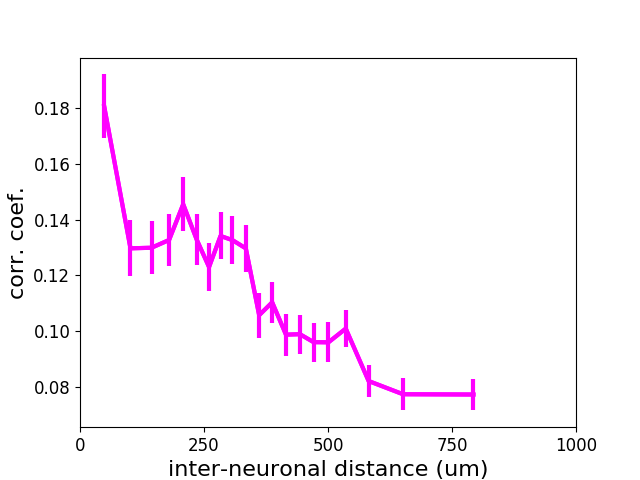

Text(0,0.5,u'corr. coef.')

In [99]:
fig, ax = pl.subplots()
binned_ = [(vals['distance'].mean(), vals['corrcoef'].mean(), spstats.sem(vals['corrcoef']) )\
           for b, vals in corrdf.groupby(['binned_dist'])]

bin_names = [b[0] for b in binned_]
bin_ccs = [b[1] for b in binned_]
bin_sems = [b[2] for b in binned_]
ax.plot(bin_names, bin_ccs, color=area_colors[visual_area], 
       label='%s' % (visual_area), lw=3)
ax.errorbar(bin_names, bin_ccs, yerr=bin_sems, color=area_colors[visual_area], lw=3)

xticks = np.linspace(0, 1000, 5)
ax.set_xticks(xticks)
ax.set_xticklabels([int(b) for b in xticks])
ax.set_xlabel('inter-neuronal distance (um)')
ax.set_ylabel('corr. coef.')

In [131]:
fig_id

NameError: name 'fig_id' is not defined

<IPython.core.display.Javascript object>


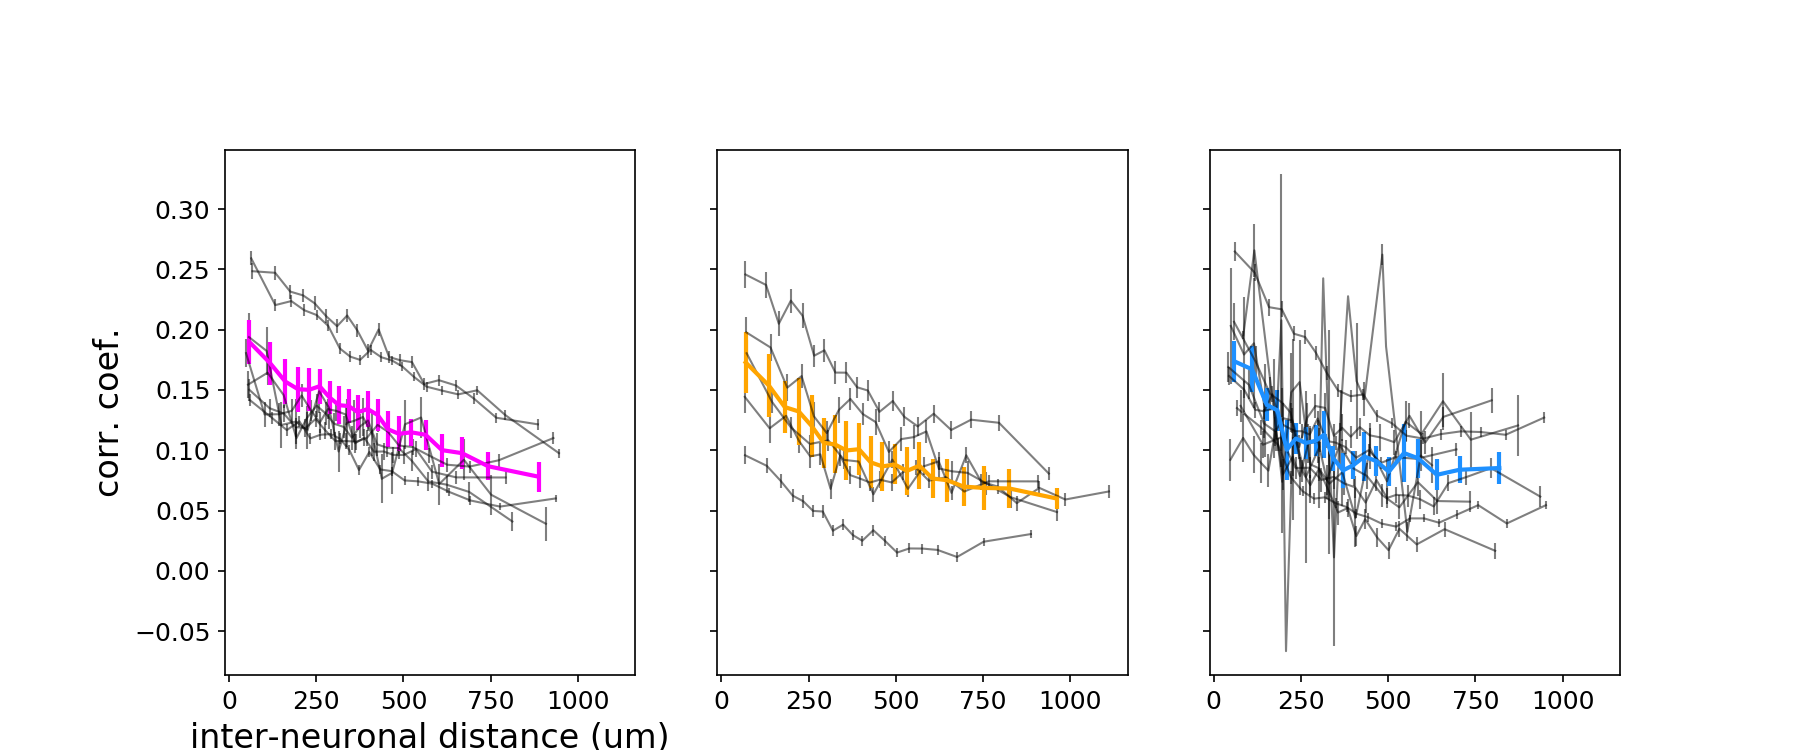

('/n/coxfs01/julianarhee/aggregate-visual-areas/spatial-correlations', 'trial-mean-ccs_distances_pairwise_per-fov_blobs_df-ROC-thr-0.05')


In [277]:
curr_exp = 'blobs'

mean_bin_names = dict((v, []) for v in visual_areas)
mean_bin_ccs = dict((v, []) for v in visual_areas)

fig, axes = pl.subplots(1, 3, figsize=(12,5), dpi=150, sharey=True, sharex=True)

for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    
    if visual_area == 'V1':
        ax = axes[0]
    elif visual_area == 'Lm':
        ax = axes[1]
    else:
        ax = axes[2]
    
    datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
    if '%s_%s' % (session, animalid) in blobs_exclude:
        continue
        
    if curr_exp == 'blobs':
        DATA = BLOBS.copy()
    elif curr_exp =='gratings':
        DATA = GRATINGS.copy()
        
    if datakey not in DATA.keys():
        continue
    
    # Get curr cells and trial values
    curr_rois = [int(r) for r in DATA[datakey]['data'].columns if r!='config']
    tstats = DATA[datakey]['data'][curr_rois]

    # zscore trial values
    tstats = (tstats - tstats.mean(axis=0)) / tstats.std(axis=0)

    # Get corrcoefs for mean trial vectors
    trialmean_ccs = unpack_square_matrix(tstats.corr(), name='corrcoef', return_combos=True)

    # Get current data set cells and positions
    currpos = posdf[(posdf['animalid']==animalid) 
                      & (posdf['session']==session) & (posdf['fov']==fov) 
                      & (posdf['index'].isin(curr_rois))][['ap_pos', 'ml_pos']]

    # Get pairwise distances for curr cells
    # Get distances bw pairs of neurons
    pwdists_sq = pd.DataFrame(squareform(pdist(currpos[['ml_pos', 'ap_pos']], metric='euclidean')),
                              columns=curr_rois, index=curr_rois)
    pwdists = unpack_square_matrix(pwdists_sq, name='distance', return_combos=True)

    # bin corrcoefs by distance
    corrdf = pd.merge(trialmean_ccs, pwdists)
#     corrdf = pd.DataFrame({'distance': pwdists,
#                            'corrcoef': trialmean_ccs})
    corrdf['binned_dist'] = pd.qcut(corrdf['distance'], n_bins, labels=False)

    # plot
    binned_ = [(vals['distance'].mean(), vals['corrcoef'].mean(), spstats.sem(vals['corrcoef']) )\
               for b, vals in corrdf.groupby(['binned_dist'])]

    bin_names = [b[0] for b in binned_]
    bin_ccs = [b[1] for b in binned_]
    bin_sems = [b[2] for b in binned_]
    #ax.plot(bin_names, bin_ccs, color=area_colors[visual_area], 
    #      label='%s' % (visual_area), lw=2)
    ax.errorbar(bin_names, bin_ccs, yerr=bin_sems, color='k', #area_colors[visual_area], 
                lw=1, alpha=0.5)

    mean_bin_names[visual_area].append(bin_names)
    mean_bin_ccs[visual_area].append(bin_ccs)
    
xticks = np.linspace(0, 1000, 5)
ax.set_xticks(xticks)
ax.set_xticklabels([int(b) for b in xticks])
ax.set_xlabel('inter-neuronal distance (um)')
ax.set_ylabel('corr. coef.')

for ax, visual_area in zip(axes.flat, visual_areas):
    bin_names_ = np.array(mean_bin_names[visual_area]).mean(axis=0)
    bin_ccs_ = np.array(mean_bin_ccs[visual_area]).mean(axis=0)
    bin_sems_ = spstats.sem(np.array(mean_bin_ccs[visual_area]), axis=0)
    ax.errorbar(bin_names_, bin_ccs_, yerr=bin_sems_, color=area_colors[visual_area], lw=2, alpha=1)

pl.subplots_adjust(bottom=0.1, top=0.8)

figname = 'trial-mean-ccs_distances_pairwise_per-fov_%s_%s-%s-thr-%.2f' % (curr_exp, response_type, responsive_test, responsive_thr)
pl.savefig(os.path.join(outdir, 'trial-means', '%s.svg' % figname))
print(outdir, figname)

In [278]:
dsets.groupby(['visual_area', 'experiment']).count()

animalid  fov  session  fovnum
visual_area experiment                                
Li          blobs             10   10       10      10
            gratings           9    9        9       9
            retino             9    9        9       9
            rfs                2    2        2       2
            rfs10              9    9        9       9
Lm          blobs              5    5        5       5
            gratings           4    4        4       4
            retino             5    5        5       5
            rfs                5    5        5       5
V1          blobs              8    8        8       8
            gratings           6    6        6       6
            retino             8    8        8       8
            rfs                8    8        8       8
            rfs10              4    4        4       4

In [279]:
import copy

# Aggregate all data

In [280]:
corrdf = []
for (vis, animalid, session, fovnum), dgroup in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
    #print(datakey)

    # Get current trial means
    for experiment in ['gratings', 'blobs']:
        if experiment=='blobs':
            DATA = BLOBS.copy()
            exclude_ = copy.copy(blobs_exclude)
        else:
            DATA = GRATINGS.copy()
            exclude_ = copy.copy(gratings_exclude)

        if datakey not in DATA.keys():
            continue
            
        if '%s_%s' % (session, animalid) in exclude_:
            continue

        # Get curr cells and trial values
        curr_rois = [int(r) for r in DATA[datakey]['data'].columns if r!='config']
        tstats = DATA[datakey]['data'][curr_rois]

        # zscore trial values
        tstats = (tstats - tstats.mean(axis=0)) / tstats.std(axis=0)

        # Get corrcoefs for mean trial vectors
        trialmean_ccs = unpack_square_matrix(tstats.corr(), name='corrcoef', return_combos=True)

        # Get current data set cells and positions
        currpos = posdf[(posdf['animalid']==animalid) 
                          & (posdf['session']==session) & (posdf['fov']=='FOV%i_zoom2p0x' % fovnum) 
                          & (posdf['index'].isin(curr_rois))][['ap_pos', 'ml_pos']]

        # Get distances bw pairs of neurons
        pwdists_sq = pd.DataFrame(squareform(pdist(currpos[['ml_pos', 'ap_pos']], metric='euclidean')),
                                  columns=curr_rois, index=curr_rois)
        pwdists = unpack_square_matrix(pwdists_sq, name='distance', return_combos=True)

        # Combine into df
        tmpdf = pd.merge(trialmean_ccs, pwdists)
        tmpdf['experiment'] = [experiment for _ in np.arange(0, len(tmpdf))]
        tmpdf['visual_area'] = [vis for _ in np.arange(0, len(tmpdf))]
        tmpdf['datakey'] = [datakey for _ in np.arange(0, len(tmpdf))]
        corrdf.append(tmpdf)
    
corrdf = pd.concat(corrdf, axis=0)

In [282]:
corrdf[['visual_area', 'experiment', 'datakey']].drop_duplicates().groupby(['visual_area', 'experiment']).count()

datakey
visual_area experiment         
Li          blobs             9
            gratings          9
Lm          blobs             5
            gratings          4
V1          blobs             7
            gratings          5

## Get means per FOV 

In [283]:
means_by_fov = pd.concat([pd.DataFrame({'meancorr': g['corrcoef'].mean(),
                                        'meandist': g['distance'].mean(),
                                        'datakey': d, 
                                        'experiment': e, 
                                        'visual_area': v}, index=[i]) for i, ((v, e, d), g) in enumerate(corrdf.groupby(['visual_area', 'experiment', 'datakey']))])


In [284]:
corrdf[['visual_area', 'experiment', 'datakey']].drop_duplicates().groupby(['visual_area', 'experiment']).count()

datakey
visual_area experiment         
Li          blobs             9
            gratings          9
Lm          blobs             5
            gratings          4
V1          blobs             7
            gratings          5

In [285]:
sorted(corrdf[ (corrdf['visual_area']=='Li') & (corrdf['experiment']=='gratings')]['datakey'].unique())



['20190602_JC091_fov1',
 '20190605_JC090_fov1',
 '20190609_JC099_fov1',
 '20190614_JC091_fov1',
 '20190617_JC099_fov1',
 '20191008_JC091_fov1',
 '20191018_JC113_fov1',
 '20191105_JC117_fov1',
 '20191111_JC120_fov1']

In [264]:
outdir = os.path.join(aggregate_dir, 'spatial-correlations')
if not os.path.exists(os.path.join(outdir, 'trial-means')):
    os.makedirs(os.path.join(outdir, 'trial-means'))
print(os.path.join(outdir, 'trial-means'))

/n/coxfs01/julianarhee/aggregate-visual-areas/spatial-correlations/trial-means


In [265]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/spatial-correlations'

In [266]:
means_by_fov['experiment'].unique()

array(['blobs', 'gratings'], dtype=object)

<IPython.core.display.Javascript object>


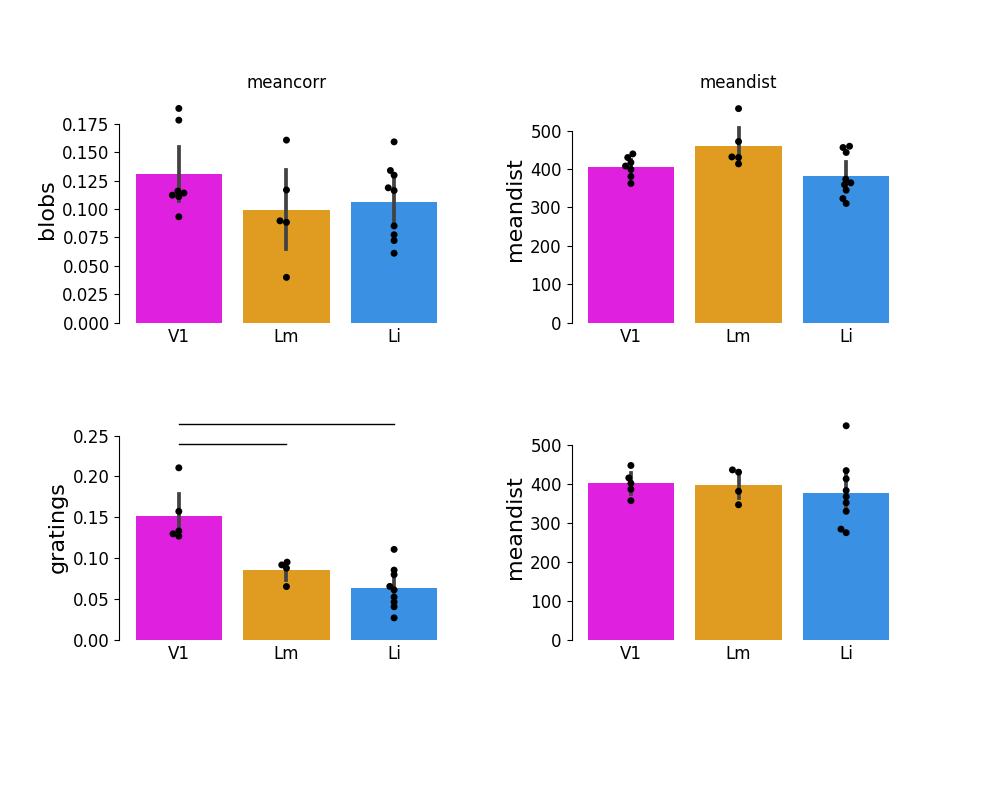

********* blobs - meancorr **********
Same distribution (fail to reject H0)
Same distribution (fail to reject H0)
Same distribution (fail to reject H0)
[(('V1', 'Lm'), False, 0.3834346613196189), (('V1', 'Li'), False, 0.52535840446624205), (('Lm', 'Li'), False, 0.52535840446624205)]
****************************
********* blobs - meandist **********
Different distribution (reject H0)
Same distribution (fail to reject H0)
Different distribution (reject H0)
[(('V1', 'Lm'), False, 0.076979855382106749), (('V1', 'Li'), False, 0.1985505729131255), (('Lm', 'Li'), False, 0.08303643937755821)]
****************************
********* gratings - meancorr **********
Different distribution (reject H0)
Different distribution (reject H0)
Same distribution (fail to reject H0)
[(('V1', 'Lm'), True, 0.019964453305216043), (('V1', 'Li'), True, 0.0050301546824194779), (('Lm', 'Li'), False, 0.0525962525600207)]
****************************
********* gratings - meandist **********
Same distribution (fail to 

In [286]:
fig, axes = pl.subplots(2,2, figsize=(10, 8))
for ei, (exp, g) in enumerate(means_by_fov.groupby(['experiment'])):
    for ai, metric in enumerate(['meancorr', 'meandist']):
        print("********* %s - %s **********" % (exp, metric))
        res = do_mannwhitney(g, metric=metric)
        print(res)
        print("****************************")

        ax = axes[ei, ai]
        sns.barplot(x='visual_area', y=metric, data=g, order=visual_areas,
                   palette=area_colors, ax=ax) #fliersize=0, ax=ax)
        sns.swarmplot(x='visual_area', y=metric, data=g, ax=ax,
                      order=visual_areas, color='k')
        
        # stats significance
        y_ht = round(ax.get_ylim()[-1], 1)*1.2
        offset = y_ht*0.1
        for ci, cpair in enumerate(res):
            if cpair[1]:
                v1, v2 = cpair[0]
                x1 = visual_areas.index(v1); x2 = visual_areas.index(v2);
                y1 = y_ht+(ci*offset); y2 = y1;
                ax.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
                
        if ai==0:
            ax.set_ylabel(exp)
        if ei==0:
            ax.set_title(metric)
        ax.set_xlabel('')
        ax.tick_params(axis='x', size=0)
        sns.despine(trim=True, offset=4, ax=ax, bottom=True)
        
pl.subplots_adjust(wspace=0.4, hspace=0.4, bottom=0.2)

figname = 'trial-mean-ccs_distances_pairwise_summary_%s-%s-thr-%.2f' % (response_type, responsive_test, responsive_thr)
pl.savefig(os.path.join(outdir, 'trial-means',  '%s.svg' % figname))


In [266]:
res

[(('V1', 'Lm'), False, 0.35311123450600557),
 (('V1', 'Li'), False, 0.35311123450600557),
 (('Lm', 'Li'), False, 0.26167200153695197)]

In [264]:
if res[0][1]:
    print('hi')

## Plot corrcoef as a function of neuronal distance

In [287]:
qcut = True
n_bins = 20
cut_type = 'quartile' if qcut else 'evenbins'

if cut_type == 'quartile':
    corrdf['binned_dist'] = pd.qcut(corrdf['distance'], n_bins, labels=False)
    _, bin_sizes = pd.qcut(corrdf['distance'], n_bins, retbins=True)
    bin_edges = bin_sizes[0:-1]
else:
    corrdf['binned_dist'] = pd.cut(corrdf['distance'], n_bins, labels=False)
    _, bin_sizes = pd.cut(corrdf['distance'], n_bins, retbins=True)
    bin_edges = bin_sizes[0:-1]

<IPython.core.display.Javascript object>


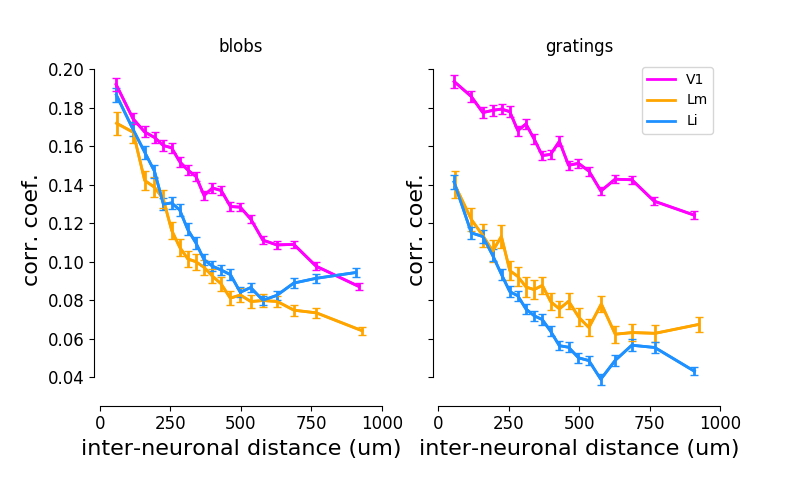

('/n/coxfs01/julianarhee/aggregate-visual-areas/spatial-correlations', '_trial-mean-ccs_by_distances_quartile-20_pairwise_ROC-thr-0.05')


In [288]:

fig, axes = pl.subplots(1,2, figsize=(8,5), sharex=True, sharey=True)

for ax, (experiment, expdf) in zip(axes.flat, corrdf.groupby(['experiment'])):

    for visual_area in visual_areas:
        tmpdf = expdf[expdf['visual_area']==visual_area]
        #ncells_t = sum([len(g['level_0'].unique()) for dk, g in currdf.groupby(['datakey'])])

        bin_dists = [vals['distance'].mean() for b, vals in tmpdf.groupby(['binned_dist'])]
        bin_ccs = [vals['corrcoef'].mean() for b, vals in tmpdf.groupby(['binned_dist'])]
        bin_sems = [spstats.sem(vals['corrcoef']) for b, vals in tmpdf.groupby(['binned_dist'])]

        ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
               label='%s' % (visual_area), lw=2)
        ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=area_colors[visual_area], 
                    lw=2, capsize=3)

        ax.set_xlabel('inter-neuronal distance (um)')
        ax.set_ylabel('corr. coef.')
    ax.set_title(experiment)

for ax in axes:
    modv = min((ax.get_xlim()[-1], 1300))
    
    if modv > 1000:
        xlm =  ax.get_xlim()[-1] - ax.get_xlim()[-1] % modv
    else:
        xlm = 1000
    xticks = np.linspace(0, round(xlm), 5)
    ax.set_xticks(xticks)
    ax.set_xticklabels([int(b) for b in xticks])
#ax.set_ylim([-0., 0.25])
sns.despine(trim=True, offset=4)
ax.legend(bbox_to_anchor=(1., 1))
pl.subplots_adjust(bottom=0.2)



figname = '_trial-mean-ccs_by_distances_%s-%i_pairwise_%s-thr-%.2f' % (cut_type, n_bins, responsive_test, responsive_thr)
pl.savefig(os.path.join(outdir, 'trial-means', '%s.svg' % figname))
print(outdir, figname)

In [289]:
import scikit_posthocs as sp
import statsmodels.stats.multicomp as ml

def calculate_stats_by_area(mdf, metric='MI', palette='colorblind', alpha=0.7, ax=None):

    if ax is None:
        fig, ax = pl.subplots()
#     g= sns.catplot(x='visual_area', y=metric, kind='bar', data=mdf, palette=palette,
#                order=['V1', 'Lm', 'Li'], alpha=alpha)
    sns.barplot(x='visual_area', y=metric, data=mdf, palette=palette,
               order=['V1', 'Lm', 'Li'], alpha=alpha, ax=ax)

    
    c1 = mdf[mdf['visual_area']=='V1'][metric]
    c2 = mdf[mdf['visual_area']=='Lm'][metric]
    c3 = mdf[mdf['visual_area']=='Li'][metric]
    print(c1.shape, c2.shape, c3.shape)

    # Shapiro-Wilk normality test 
    print("Shapiro-Wilk normality:", spstats.shapiro(c1), spstats.shapiro(c2), spstats.shapiro(c3) )

    F, p = spstats.f_oneway(c1, c2, c3)
    print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

    scores = np.hstack([c1, c2, c3])
    groups = np.hstack([['V1' for _ in range(len(c1))], 
                       ['Lm' for _ in range(len(c2))],
                       ['Li' for _ in range(len(c3))]])
    # Note that data in sheet have been preformatted in Group and Score columns 
    # Boolean values refer to whether we should reject the null hypothesis (H0) that
    # the means of the tested pair are statistically similar (non-significant differences)
    mcobj = ml.MultiComparison(scores, groups)
    out = mcobj.tukeyhsd(0.05) 
    print(out)

    print(spstats.kruskal(c1, c2, c3))
    statsdf = mdf[['visual_area', metric]].copy()
    print(sp.posthoc_dunn(statsdf, val_col=metric, group_col='visual_area', p_adjust='bonferroni')) #'fdr_by')
    
    return g

In [294]:
curr_exp = 'gratings'

variance_by_area = []
for (v, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    
    if '%s_%s' % (session, animalid) in always_exclude:
        continue

    datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
    if curr_exp == 'blobs':
        if datakey not in BLOBS.keys():
            continue
        if '%s_%s' % (session, animalid) in blobs_exclude:
            continue
        currdata = BLOBS[datakey]['data'].copy()
        
    elif curr_exp == 'gratings':
        if datakey not in GRATINGS.keys():
            continue
        if '%s_%s' % (session, animalid) in gratings_exclude:
            continue
        currdata = GRATINGS[datakey]['data'].copy()

    # Get curr cells and trial values
    #curr_rois = [int(r) for r in currdata.columns if r!='config']
    #tstats = currdata[curr_rois]

    # zscore trial values
    #tstats = (tstats - tstats.mean(axis=0)) / tstats.mean(axis=0)
    #variances = tstats.var().mean()
    
    variances = currdata.groupby(['config']).var().mean()
    variance_by_area.append(pd.DataFrame({'variance': variances,
                                            'rid': variances.index.tolist(),
                                         'visual_area': [v for _ in np.arange(0, len(variances))],
                                         'datakey': [datakey for _ in np.arange(0, len(variances))] }) )

variance_by_area = pd.concat(variance_by_area, axis=0)

In [295]:
mean_vars_by_area = variance_by_area.groupby(['visual_area', 'datakey']).mean().reset_index()

In [296]:
response_type

'df'

<IPython.core.display.Javascript object>


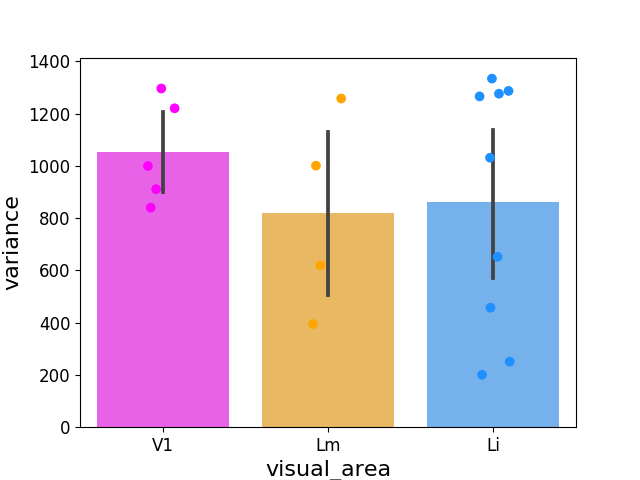

((5,), (4,), (9,))
('Shapiro-Wilk normality:', (0.9178467392921448, 0.5161452293395996), (0.9678733944892883, 0.8282732963562012), (0.8388880491256714, 0.056132178753614426))
F statistic = 0.494 and probability p = 0.620
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff   lower    upper   reject
------------------------------------------------
  Li     Lm   -43.4663 -665.9056 578.973  False 
  Li     V1   191.8065  -385.936 769.5491 False 
  Lm     V1   235.2729  -459.564 930.1097 False 
------------------------------------------------
KruskalResult(statistic=0.65087719298244906, pvalue=0.72221052516495909)
     Li   Lm   V1
Li -1.0  1.0  1.0
Lm  1.0 -1.0  1.0
V1  1.0  1.0 -1.0
variance-per-fov_no-repeats_gratings_df-ROC-thr-0.05


In [297]:
ax = calculate_stats_by_area(mean_vars_by_area, metric='variance', 
                            palette=area_colors, alpha=0.7)
sns.stripplot(x='visual_area', y='variance', data=mean_vars_by_area,
             palette=area_colors, order=visual_areas, size=7)


figname = 'variance-per-fov_no-repeats_%s_%s-%s-thr-%.2f' % (curr_exp, response_type, responsive_test, responsive_thr)
pl.savefig(os.path.join(outdir, 'trial-means', '%s.svg' % figname))
print(figname)

In [300]:
from pipeline.python.classifications import aggregate_data_stats as aggr

In [298]:
dfn = '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/data_arrays/np_subtracted.npz'
d = np.load(dfn)


In [299]:
d.keys()

['f0',
 'labels_columns',
 'sconfigs',
 'file_ixs',
 'run_info',
 'labels_data',
 'data']

In [302]:
reload(aggr)
reload(util)

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julian

<module 'pipeline.python.classifications.experiment_classes' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.pyc'>

In [304]:
animalid= 'JC084'
session = '20190522'
traces, labels, sdf = aggr.load_traces(animalid, session, fovnum, 'gratings', response_type='df')


... [JC084|20190522|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static']
... run: combined_gratings_static
... loading data array
NP_subtracted offset was: 97.80
adding NP offset... (NP baseline offset: 608.37)
((138880, 260), (260,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static


# Look at distn of trial values

In [398]:
zscores = []
for (vis, animalid, session, fovnum), dgroup in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
    #print(datakey)

    # Get current trial means
    for experiment in ['gratings']: #, 'gratings']:
        if experiment=='blobs':
            DATA = BLOBS.copy()
        else:
            DATA = GRATINGS.copy()
        if datakey not in DATA.keys():
            continue
            
        curr_rois = [int(r) for r in DATA[datakey]['data'].columns if r!='config']
        tstats = DATA[datakey]['data'][curr_rois]

        tstats = (tstats - tstats.mean(axis=0)) / tstats.std(axis=0)
        zs = tstats.values.ravel()
        zscores.append(pd.DataFrame({'zscore': zs,
                                     'experiment': [experiment for _ in np.arange(0, len(zs))],
                      'visual_area': [vis for _ in np.arange(0, len(zs))],
                      'datakey': [datakey for _ in np.arange(0, len(zs))]}))
zscores = pd.concat(zscores, axis=0)

In [399]:
zscores.shape

(2447733, 4)

In [420]:
zscore_means_by_fov = pd.concat([pd.DataFrame({'meanzscore': g['zscore'].mean(),
                                        'datakey': d, 
                                        'experiment': e, 
                                        'visual_area': v}, index=[i]) for (v, e, d), g in zscores.groupby(['visual_area', 'experiment', 'datakey'])])


In [421]:
zscore_means_by_fov

datakey experiment    meanzscore visual_area
236  20190602_JC091_fov1   gratings  5.312469e-17          Li
236  20190605_JC090_fov1   gratings -1.047310e-17          Li
236  20190606_JC091_fov1   gratings -4.232725e-17          Li
236  20190607_JC091_fov1   gratings  9.748300e-18          Li
236  20190609_JC099_fov1   gratings -3.785679e-17          Li
236  20190612_JC099_fov1   gratings -6.211776e-17          Li
236  20190614_JC091_fov1   gratings  2.346348e-17          Li
236  20190617_JC099_fov1   gratings  4.289498e-17          Li
236  20191008_JC091_fov1   gratings  7.250436e-18          Li
236  20191018_JC113_fov1   gratings  1.459150e-17          Li
236  20191105_JC117_fov1   gratings -1.168656e-16          Li
236  20191111_JC120_fov1   gratings -1.697988e-17          Li
236  20190512_JC083_fov1   gratings  7.325751e-17          Lm
236  20190513_JC078_fov1   gratings -3.430970e-17          Lm
236  20190517_JC083_fov1   gratings  4.526667e-17          Lm
236  20190525_JC084_fov1   gratings -3.604959e-17          Lm
236  20190603_JC080_fov1   gratings  6.769653e-18          Lm
236  20190627_JC091_fov1   gratings -1.145283e-16          Lm
236  20190511_JC083_fov1   gratings  9.657862e-17          V1
236  20190613_JC097_fov1   gratings  5.588538e-17          V1
236  20190616_JC097_fov1   gratings  1.424885e-18          V1
236  20190617_JC097_fov1   gratings -5.843279e-17          V1
236  20190622_JC085_fov1   gratings -3.952626e-17          V1
236  20191006_JC110_fov1   gratings -3.688806e-17          V1

<IPython.core.display.Javascript object>


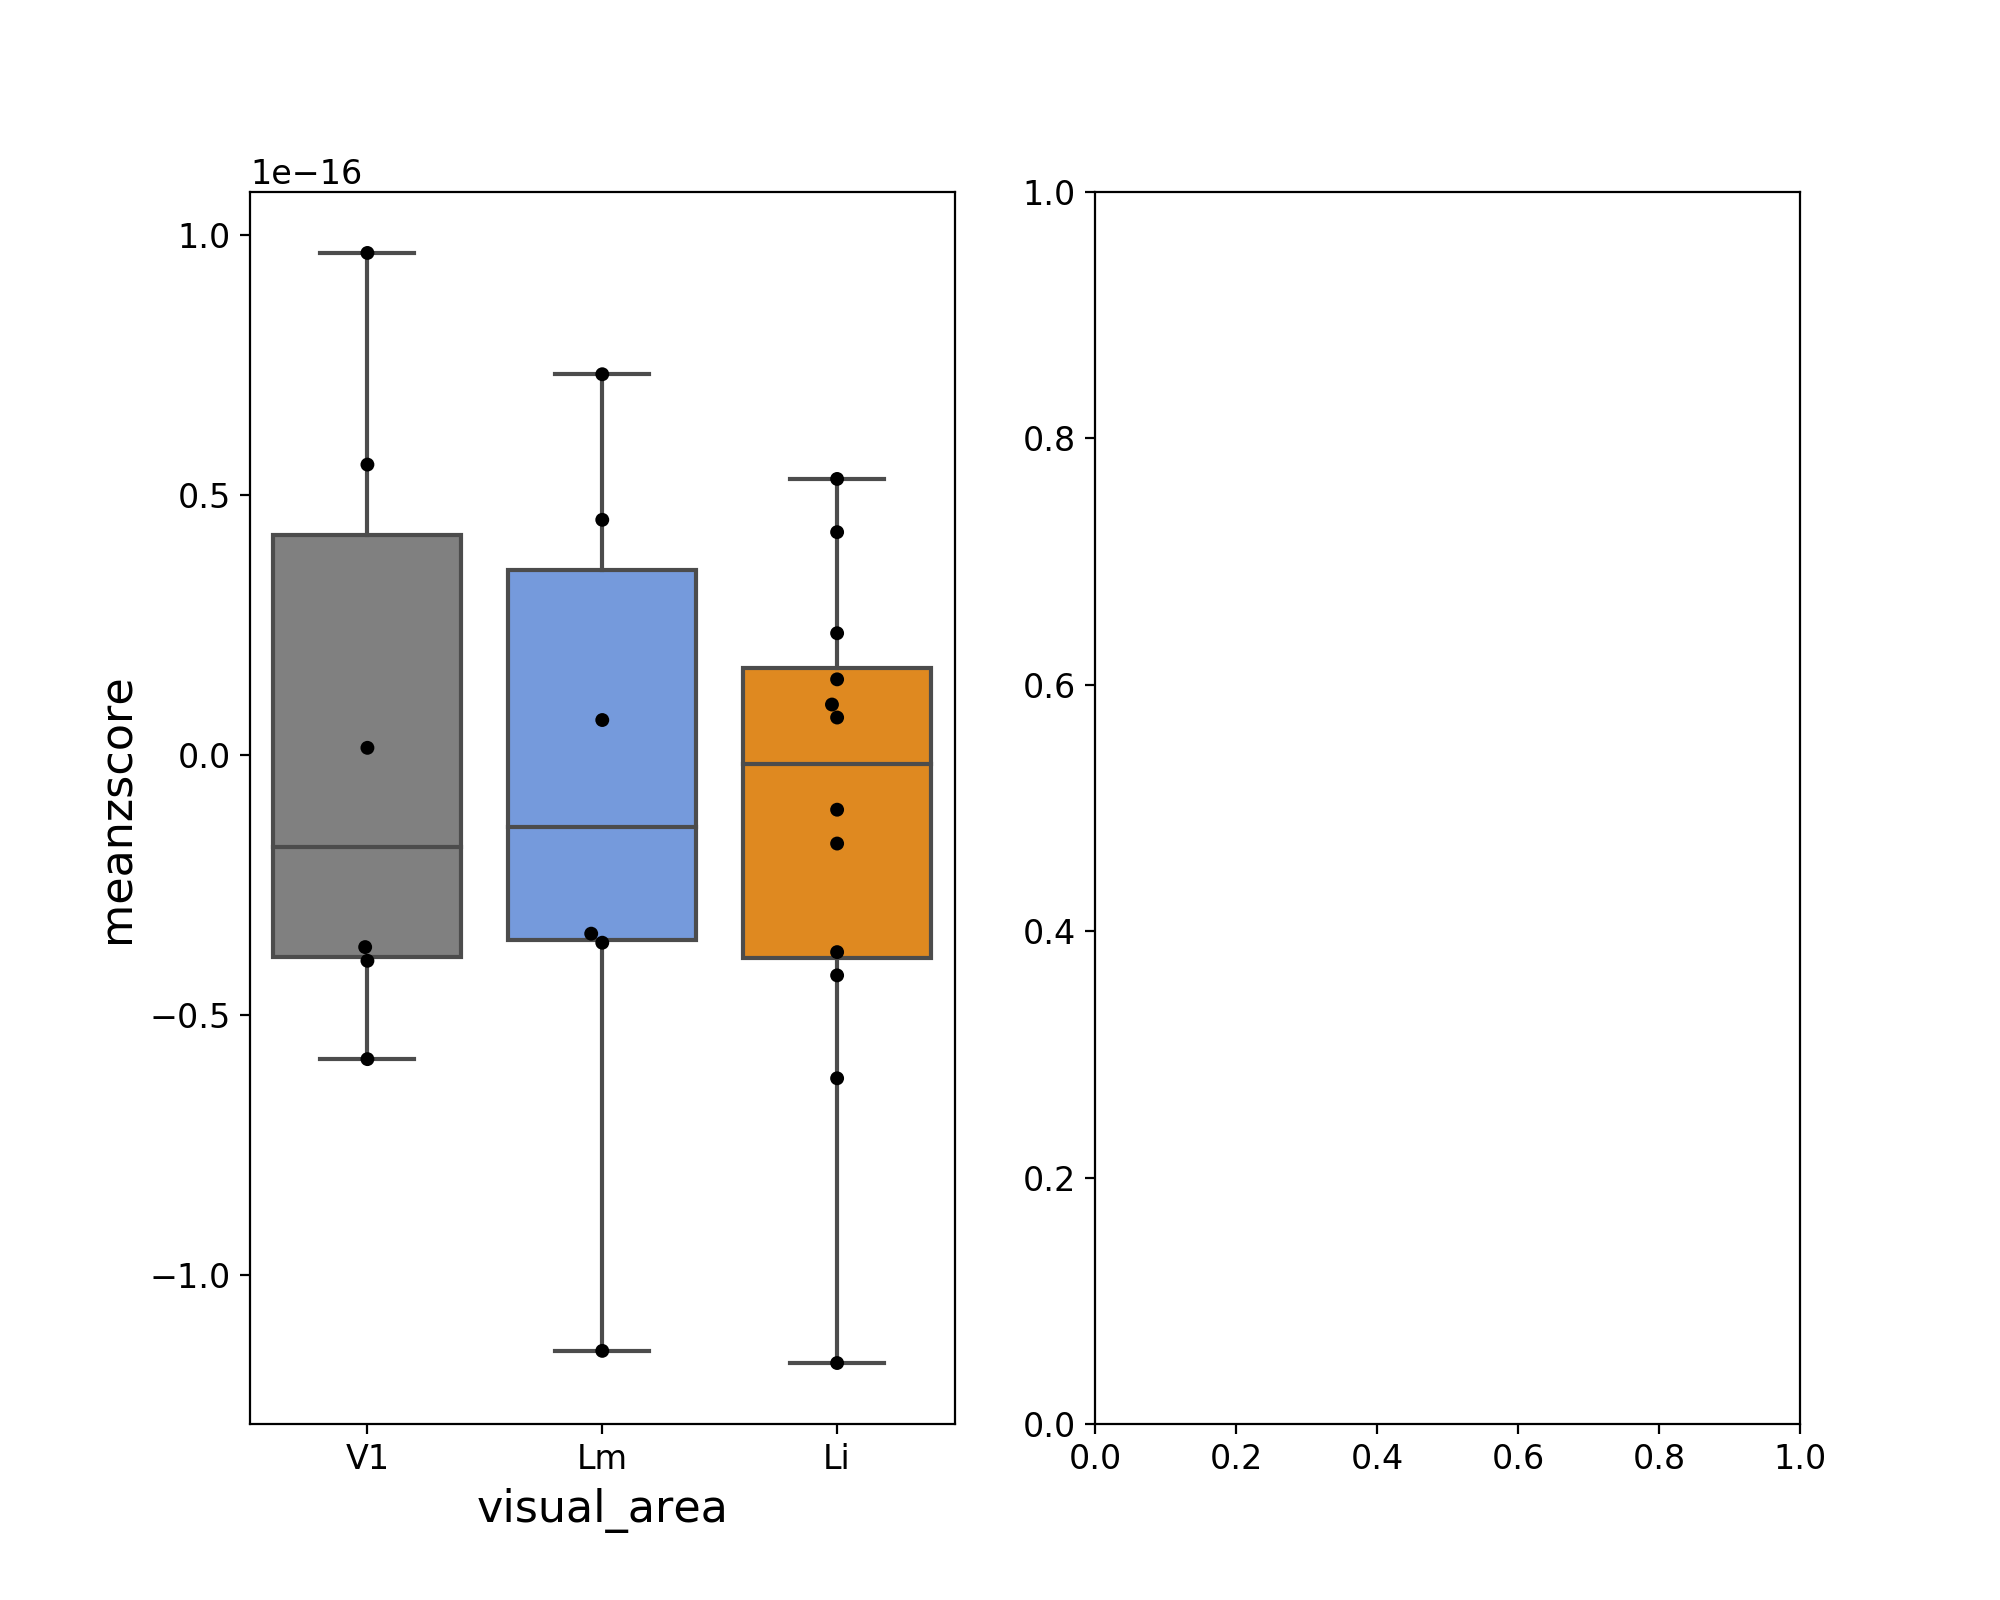

********* gratings - meanzscore **********
Same distribution (fail to reject H0)
Same distribution (fail to reject H0)
Same distribution (fail to reject H0)
[(('V1', 'Lm'), False, 1.0), (('V1', 'Li'), False, 1.0), (('Lm', 'Li'), False, 1.0)]
****************************


In [425]:
metric='meanzscore'
fig, axes = pl.subplots(1, 2, figsize=(10, 8))
for ei, (exp, g) in enumerate(zscore_means_by_fov.groupby(['experiment'])):
    print("********* %s - %s **********" % (exp, metric))
    res = do_mannwhitney(g, metric=metric)
    print(res)
    print("****************************")

    ax = axes[ei]
    sns.boxplot(x='visual_area', y=metric, data=g, order=visual_areas,
               palette=area_colors, ax=ax) #fliersize=0, ax=ax)
    sns.swarmplot(x='visual_area', y=metric, data=g, ax=ax,
                  order=visual_areas, color='k')

In [426]:
zscores['abs_zscore'] = np.abs(zscores['zscore'])

In [427]:
experiment_list = ['gratings', 'blobs']

<IPython.core.display.Javascript object>


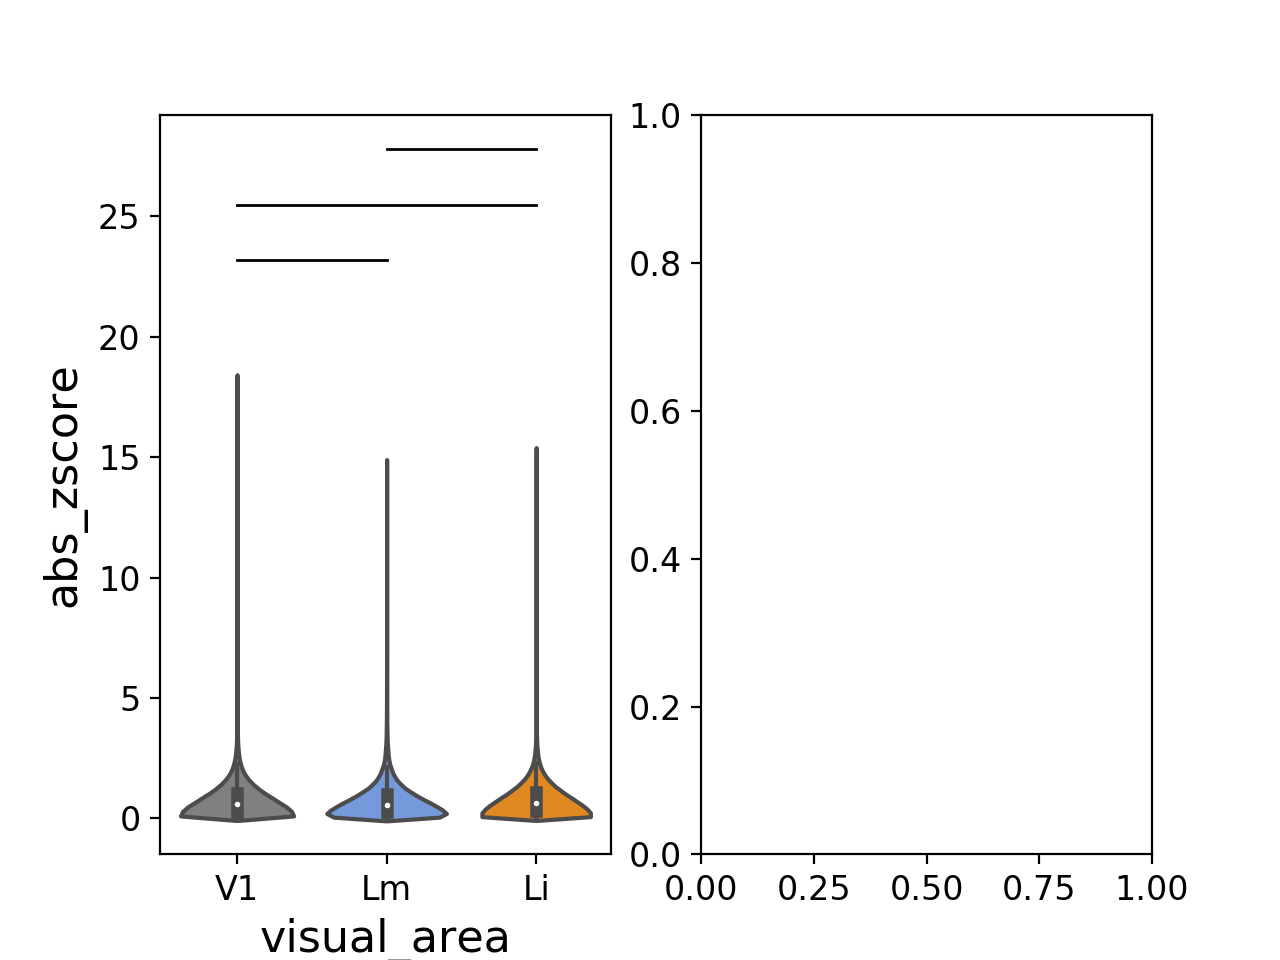

********* gratings - zscored vals **********
Different distribution (reject H0)
Different distribution (reject H0)
Different distribution (reject H0)
[(('V1', 'Lm'), True, 7.4840053983657469e-245), (('V1', 'Li'), True, 2.42060589344768e-46), (('Lm', 'Li'), True, 0.0)]
                   zscore  abs_zscore
visual_area                          
Li          -1.179358e-17    0.771475
Lm           1.470438e-17    0.739405
V1           8.326314e-17    0.763240
****************************


In [428]:
metric = 'abs_zscore'
fig, axes = pl.subplots(1, len(experiment_list))
ai = 0
for experiment, zgroup in zscores.groupby(['experiment']):
    ax = axes[ai]
    sns.violinplot(x='visual_area', y=metric, data=zgroup, ax=ax,
                palette=area_colors, order=visual_areas)
    
    print("********* %s - zscored vals **********" % (experiment))
    res = do_mannwhitney(zgroup, metric=metric)
    print(res)
    print(zgroup.groupby(['visual_area']).mean())
    print("****************************")
    
    y_ht = round(ax.get_ylim()[-1], 1)*1.2
    offset = y_ht*0.1
    for ci, cpair in enumerate(res):
        if cpair[1]:
            v1, v2 = cpair[0]
            x1 = visual_areas.index(v1); x2 = visual_areas.index(v2);
            y1 = y_ht+(ci*offset); y2 = y1;
            ax.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
                
    ai += 1

<IPython.core.display.Javascript object>


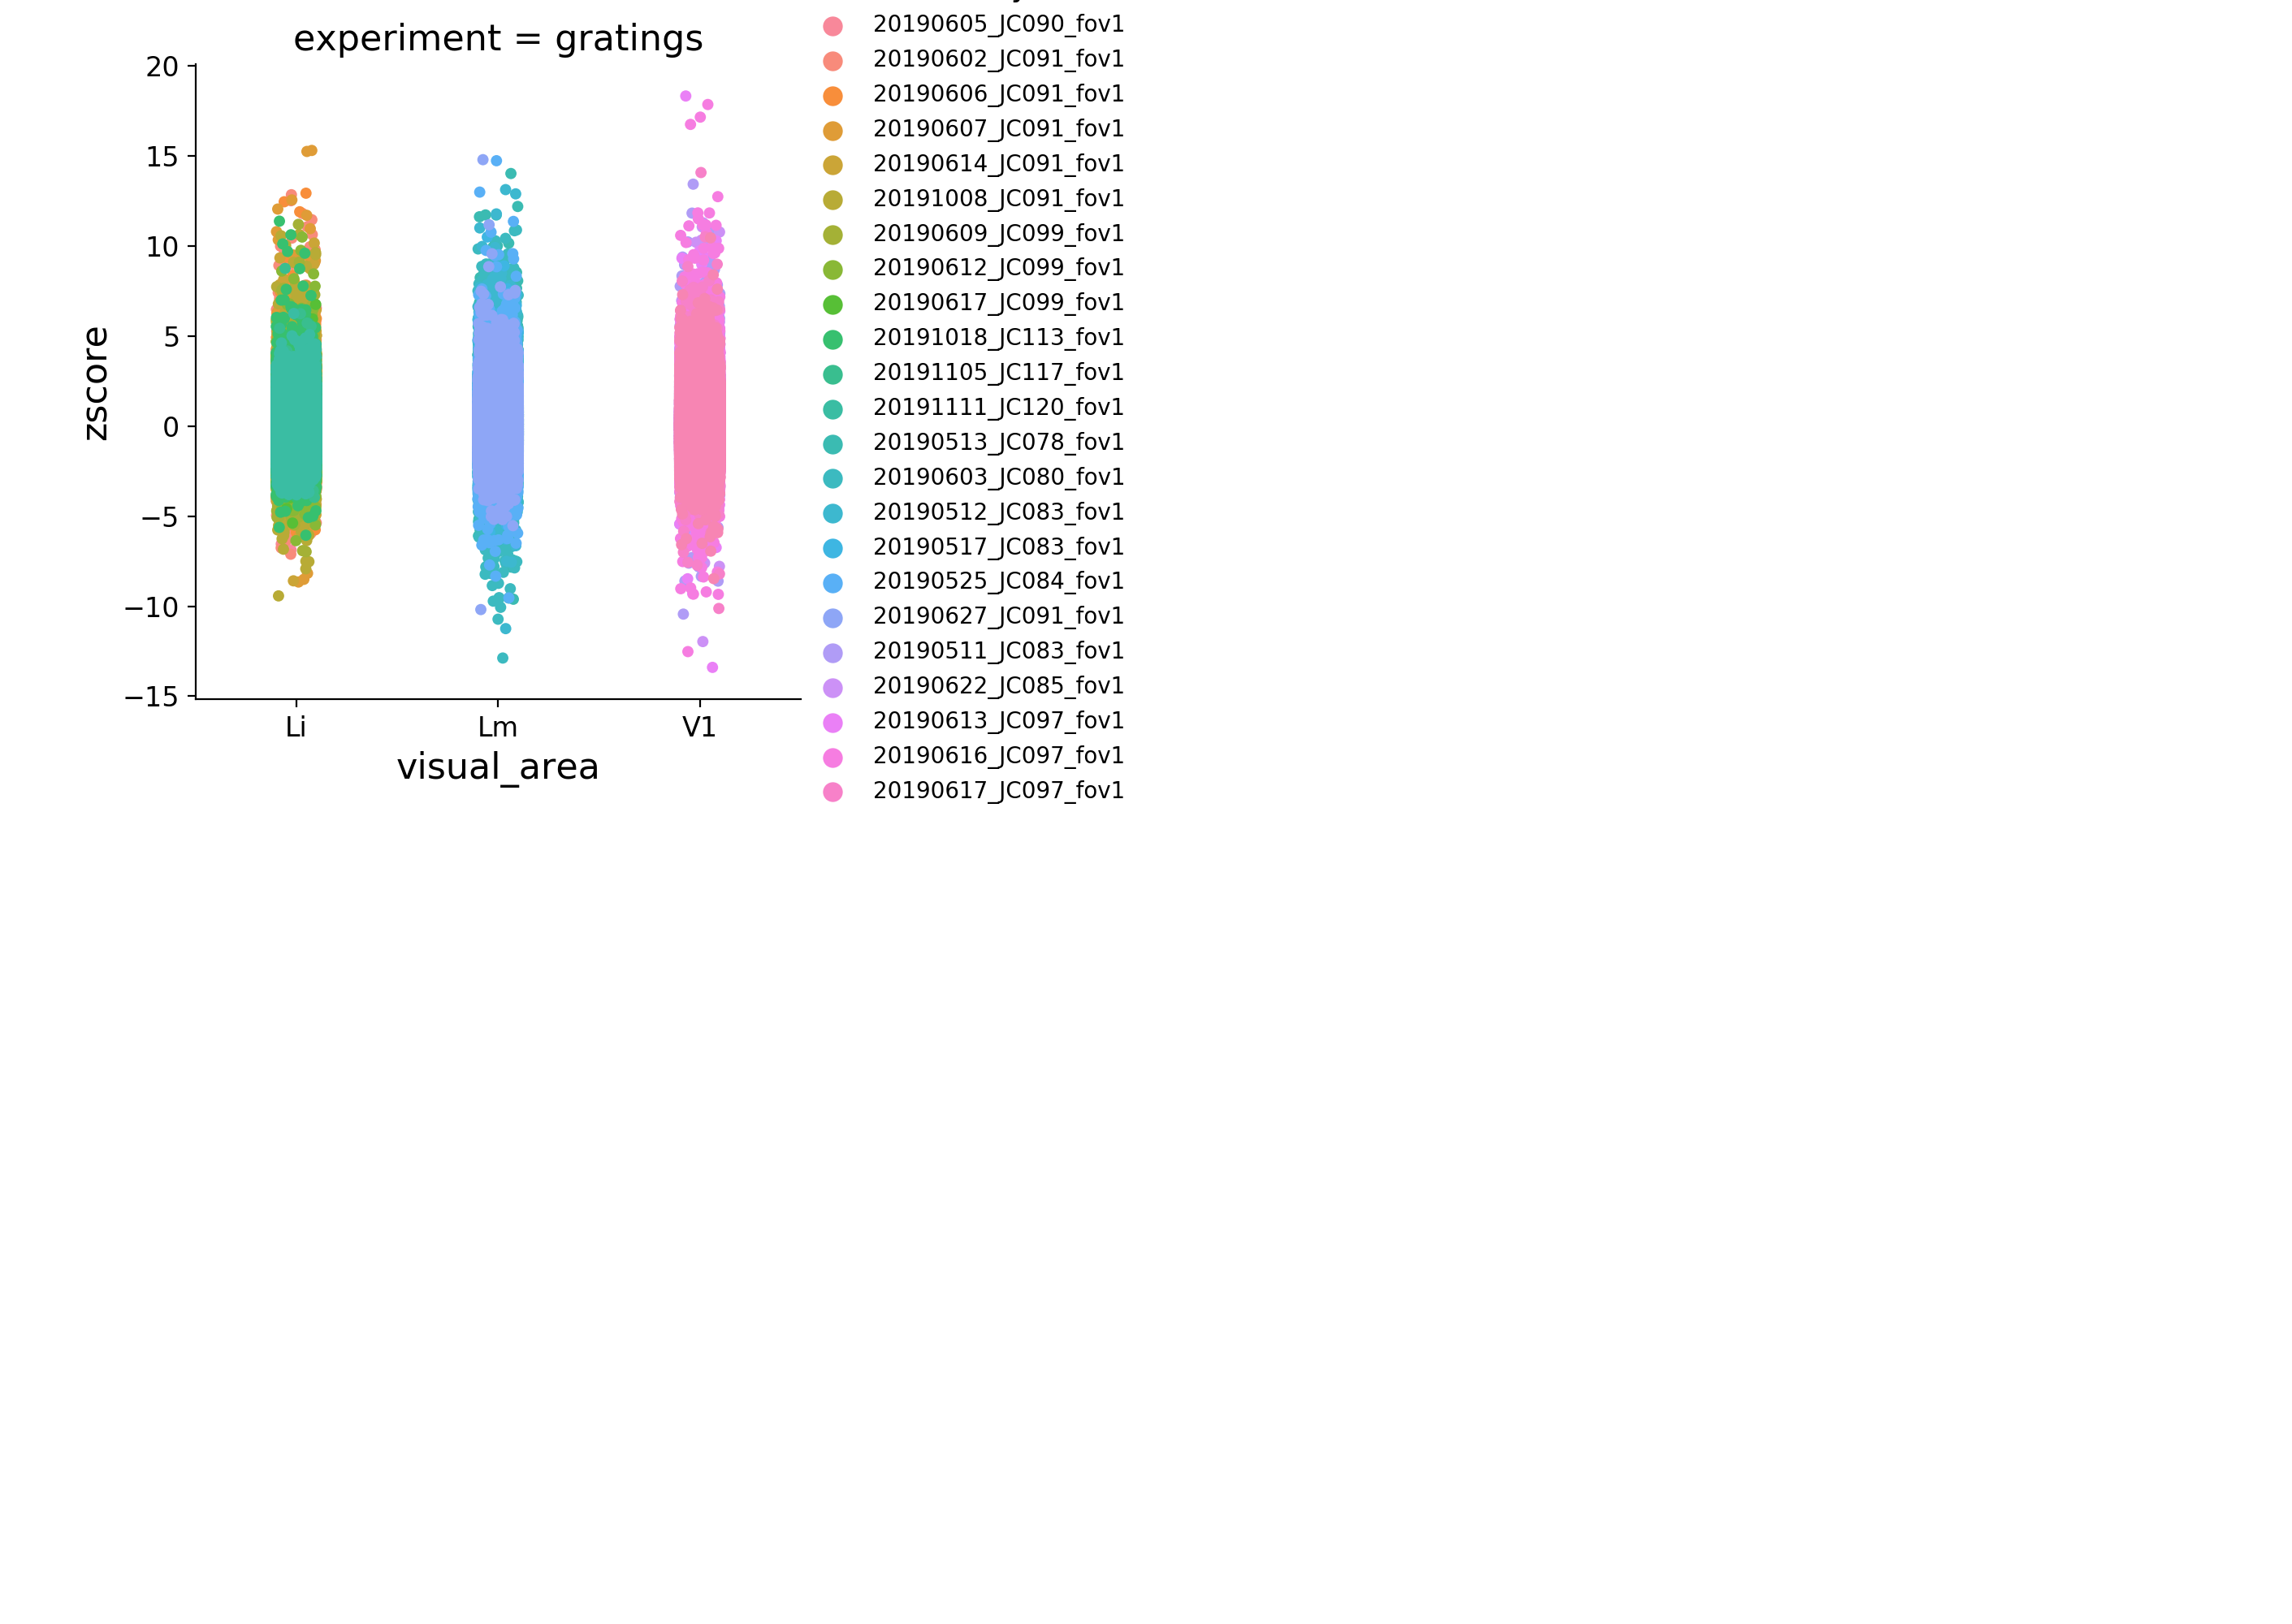

In [401]:
sns.catplot(x='visual_area', y='zscore', hue='datakey', data=zscores, col='experiment')

#### For each cell, look at correlation between its distances to all other cells vs. correlation between its activity to all other cells' activity

In [19]:
print len(roi_list)
print np.sqrt(len(roi_list))

NameError: name 'roi_list' is not defined

In [20]:
corr = tstats.corr(method='pearson')


NameError: name 'tstats' is not defined

<IPython.core.display.Javascript object>


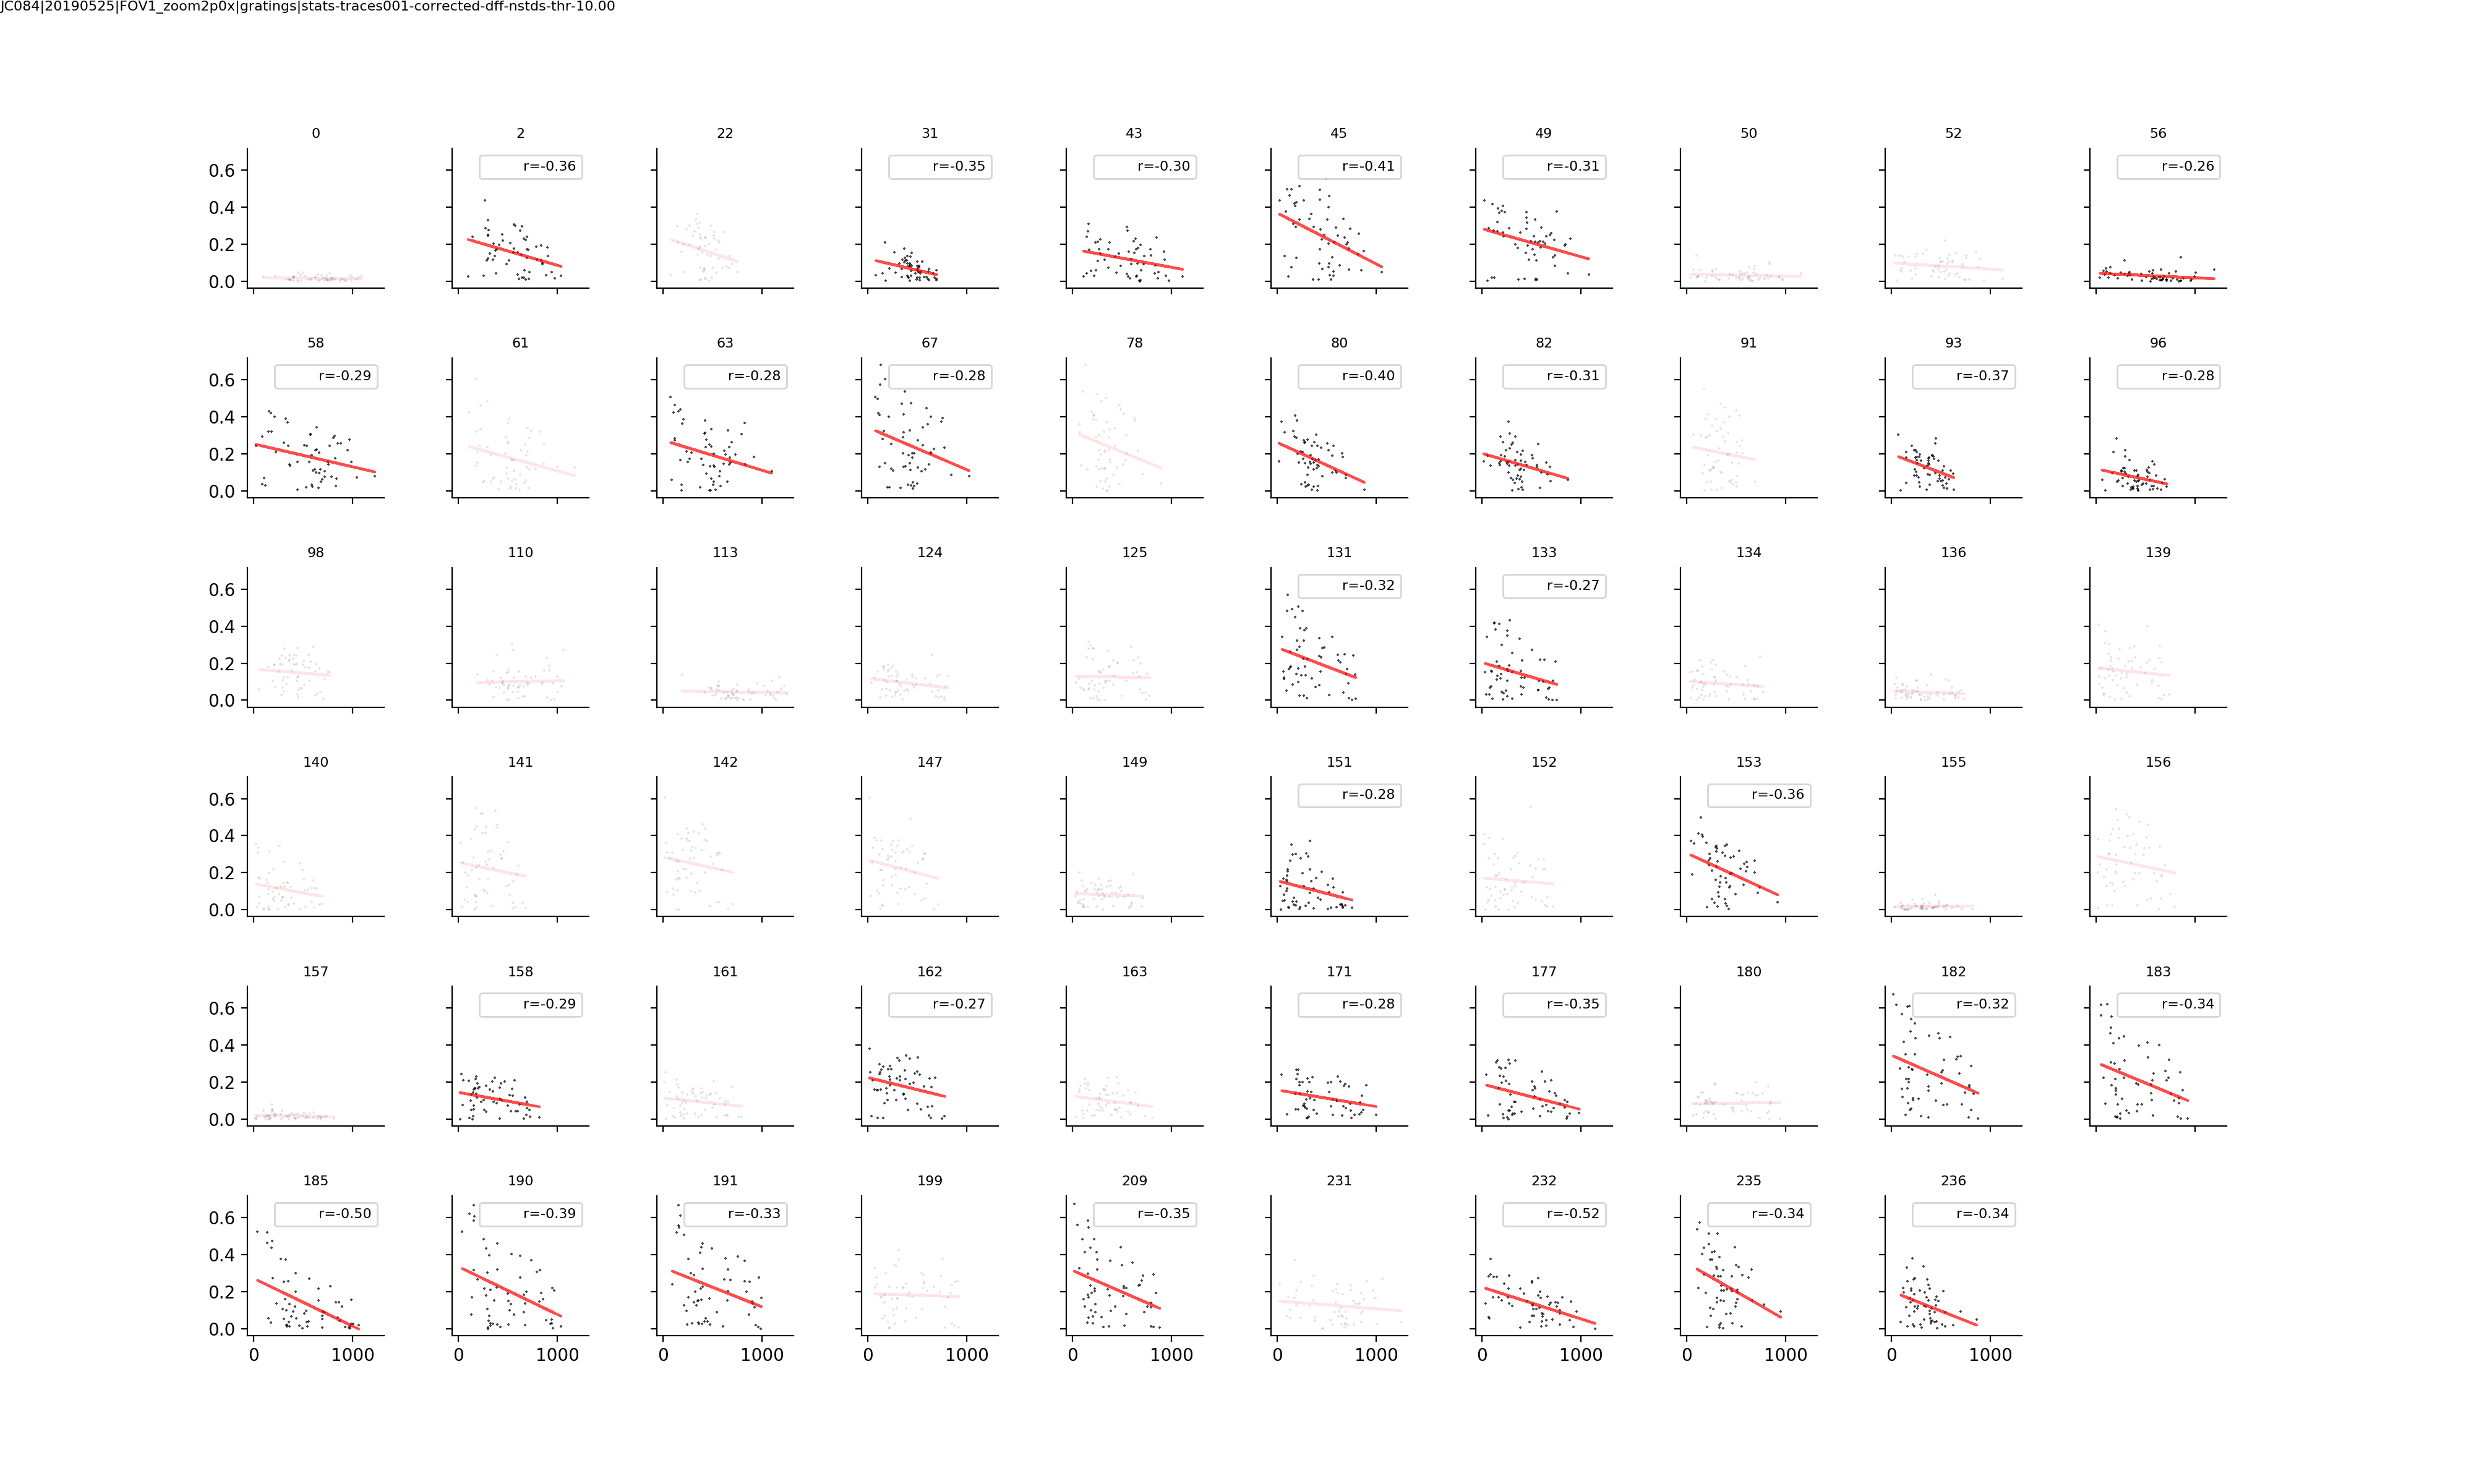

In [56]:
nplots = 60

nr = 6
nc = 10

coeffs = []
fig, axes = pl.subplots(nr, nc, sharex=True, sharey=True, figsize=(nc*2,nr*2))
fig.patch.set_alpha(1)
ai = 0
for roi in roi_list: #[0:nplots]:
    ax = axes.flat[ai]
    currp = currpos.loc[roi]

    curr_dists = (currpos[['ap_pos', 'ml_pos']] - np.array(currp)).pow(2).sum(1).pow(0.5).values
    ixs = np.array([i for i, r in enumerate(currpos.index.tolist()) if r != roi])
    curr_dists = curr_dists[ixs]
    
    curr_corrs = np.abs(corr[roi].values)
    ixs = np.array([i for i, r in enumerate(corr[roi].index.tolist()) if r!= roi])
    curr_corrs = curr_corrs[ixs]

    fitv, regr = fit_linear_regr(curr_dists, curr_corrs, return_regr=True)
    r, p = spstats.pearsonr(curr_dists, curr_corrs)
    label = 'r=%.2f' % r
    ax.plot(0, 0, alpha=0, label=label)
    if p < 0.05:
        ax.legend(loc='upper right', fontsize=8)
        alpha=0.7
        coeffs.append((roi, r))
    else:
        alpha=0.1
    
    ax.scatter(curr_dists, curr_corrs, marker='+', s=1, c='k', alpha=alpha)
    ax.plot(curr_dists, fitv, 'r', alpha=alpha)
    ax.set_title(roi, fontsize=8)

    sns.despine(ax=ax)
    ai += 1

pl.subplots_adjust(wspace=0.5, hspace=0.5, left=0.1, right=0.9, top=0.9, bottom=0.1)
for ax in axes.flat[ai:]:
    ax.axis('off')
    
    
label_figure(fig, '|'.join([animalid, session, fov, 'gratings', stats_desc]))
pl.savefig(os.path.join(aggregate_dir, 'pw-distances_vs_cell-cell-corrs_example.png'))

## Compare to RF deviants

In [76]:
fovdir = os.path.join(rootdir, animalid, session, fov)
rf_deviant_fpath = glob.glob(os.path.join(fovdir, 'combined_*_static', 'traces', '%s*' % traceid,\
                      'receptive_fields', 'fit-*', 'evaluation', 'good_bad_weird*.json'))[0]
with open(rf_deviant_fpath, 'r') as f:
    rf_deviants = json.load(f)
rf_deviants.keys()

[u'elevation', u'azimuth']

In [87]:
dev_either = np.union1d(rf_deviants['azimuth']['deviants'], rf_deviants['elevation']['deviants'])
dev_both = np.intersect1d(rf_deviants['azimuth']['deviants'], rf_deviants['elevation']['deviants'])

negcorr_rois = [r[0] for r in coeffs]

print len(negcorr_rois), len(dev_either)

len([d for d in negcorr_rois if d in dev_both])


30 21


2

In [88]:
dev_both

array([ 16,  31,  45, 112, 201, 210])

####  Look at distn of corr coeffs

<IPython.core.display.Javascript object>


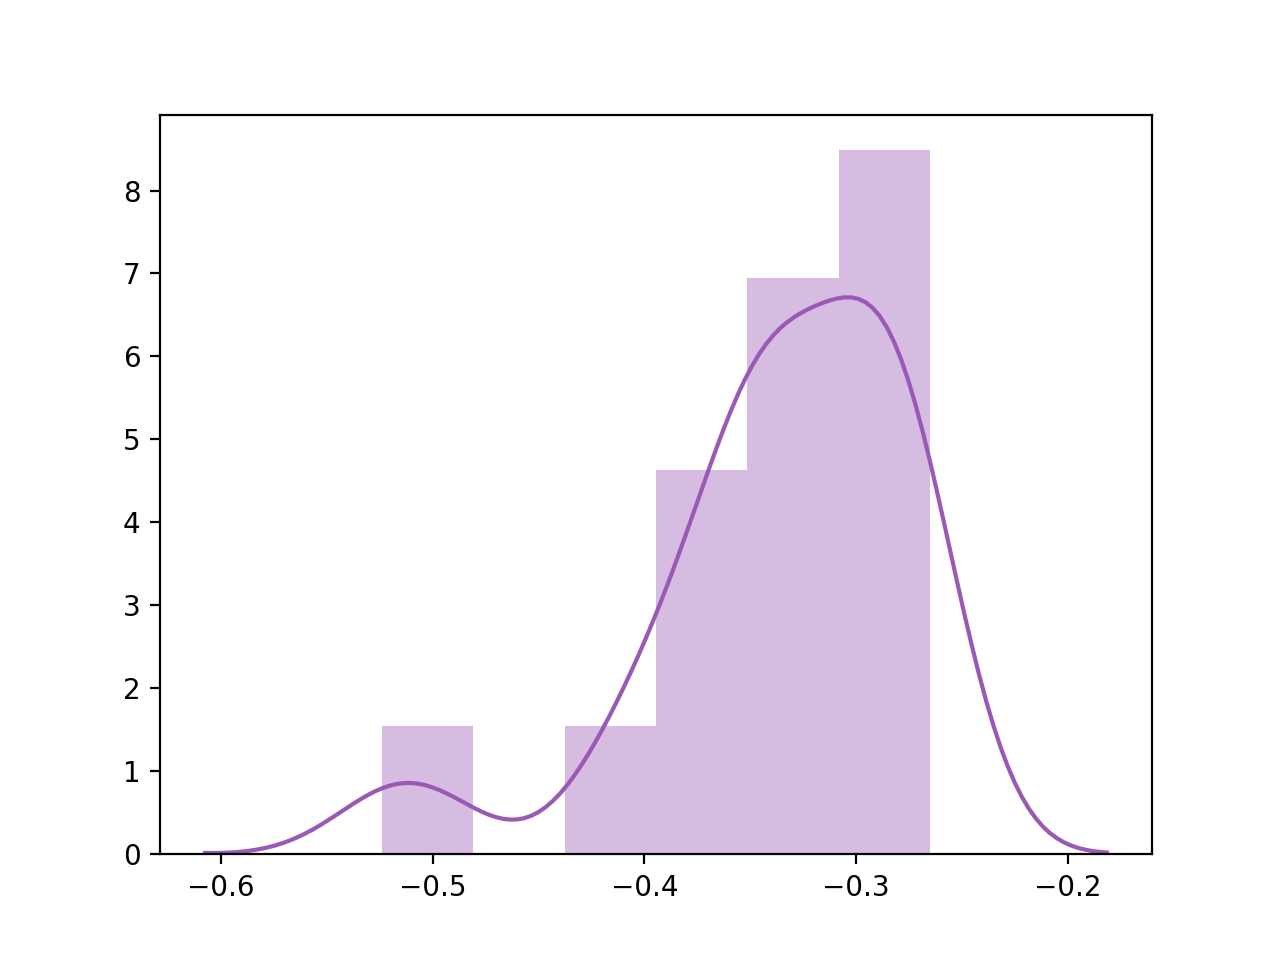

In [89]:
fig, ax = pl.subplots()
coeff_vals = [c[1] for c in coeffs]
sns.distplot(coeff_vals, ax=ax)

#### Grab upper diagonal of correlations

In [90]:
ucorr = corr.where(np.triu(np.ones(corr.shape), 1).astype(np.bool))
ucorr = ucorr.stack().reset_index()
ucorr.shape
ucorr.columns = ['row', 'col', 'value']

#### Calculate pairwise distances

In [91]:
pwdists = pdist(currpos[['ml_pos', 'ap_pos']], metric='euclidean')

In [92]:
currpos[['ml_pos', 'ap_pos']]

ml_pos       ap_pos
index                         
0      280.435726    46.330489
2      356.744767   113.509699
22     341.482959   410.024830
31     270.897096   451.722270
43     497.916493    83.394881
45     610.472329   196.904579
49     621.918685   178.372384
50     608.564603    83.394881
52     671.519562   157.523663
56     637.180493    57.913112
58     724.935890    67.179209
61     835.584000   208.487202
63     728.751342   222.386348
67     671.519562   273.349886
78     606.656877   389.176110
80     537.978740   359.061292
82     522.716932   363.694341
91     434.961534   518.901479
93     375.822027   555.965871
96     310.959342   620.828556
98     284.251178   671.792094
110    150.710356   935.875883
113     95.386301  1118.881315
124    442.592438   803.833988
125    452.131068   769.086121
131    509.362849   801.517464
133    528.440110   757.503499
134    558.963726   764.453072
136    558.963726   725.072157
139    585.671890   713.489534
140    579.948712   667.159045
141    566.594630   630.094654
142    593.302795   623.145080
147    608.564603   627.778129
149    629.549589   648.626849
151    612.380055   720.439108
152    591.395068   690.324290
153    566.594630   331.262998
155    726.843616   597.663311
156    717.304986   706.539961
157    721.120438   725.072157
158    713.489534   738.971303
161    728.751342   697.273863
162    707.766356   692.640814
163    732.566795   627.778129
171    801.244932   894.178442
177    757.367233   903.444540
180    700.135452   889.545393
182    591.395068   861.747100
183    612.380055   908.077589
185    629.549589  1047.069057
190    648.626849  1012.321190
191    496.008767  1010.004665
199    539.886466   928.926309
209    578.040986   873.329722
231    732.566795    46.330489
232    658.165479   125.092321
235    709.674082   393.809159
236    700.135452   507.318857

<IPython.core.display.Javascript object>


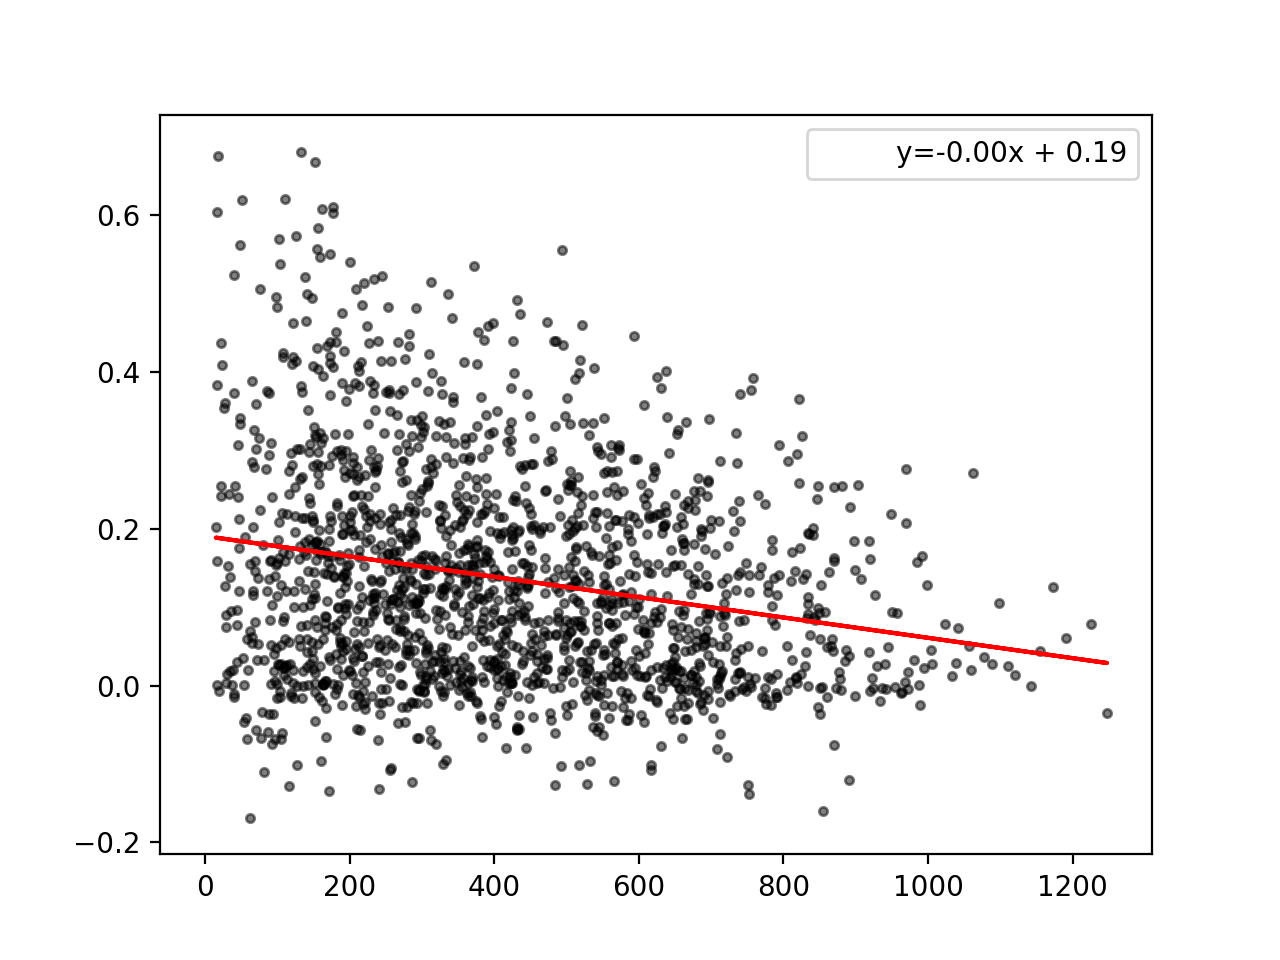

In [93]:

xv = pwdists
yv = ucorr['value']#**2. #np.abs(ucorr['value'].values)

fitv, regr = fit_linear_regr(xv, yv, return_regr=True)

fig, ax = pl.subplots() #pl.figure()
ax.scatter(xv, yv, marker='.', alpha=0.5, c='k', label=None)
ax.plot(xv, fitv, 'r')
ax.plot(0,0, alpha=0, label='y=%.2fx + %.2f' % (float(regr.coef_), float(regr.intercept_)))

ax.legend(loc='upper right')

# Aggregate all data

In [21]:
corr_method = 'pearson'

# Correlate shared ROIs

In [24]:
corrcoef_fpath = os.path.join(aggregate_dir, 'soma-dist_v_trial-corrs_corrcoef-%s.pkl' % corr_method)

do_correlations = False
if os.path.exists(corrcoef_fpath):
    print("... loading existing results")
    try:
        with open(corrcoef_fpath, 'rb') as f:
            df = pkl.load(f)
    except Exception as e:
        do_correlations = True
else:
    do_correlations = True
    
do_correlations

True

In [35]:
missing = []
#['20190525_JC084_fov1', '20190522_JC084_fov1']

In [36]:
rerun = []
if do_correlations:
    df_list = []
    for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
        if '%s_%s' % (session, animalid) in always_exclude or '%s_%s' % (session, animalid) in missing:
            continue
            
        datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
        fov = 'FOV%i_zoom2p0x' % fovnum
        try:
            S = util.Session(animalid, session, fov)
            all_rois = S.get_all_responsive_cells(traceid=traceid, response_type=response_type,
                                              responsive_test=responsive_test, responsive_thr=responsive_thr, fit_thr=0.5)
        except Exception as e:
            rerun.append(datakey)
            continue
            
        #### Get soma positions and RF positions
        currpos = posdf.groupby(['animalid', 'session', 'fov']).get_group((animalid, session, fov)).copy()
        #rfname = 'rfs10' if 'rfs10' in S.experiments.keys() else 'rfs'
        if 'rfs10' in S.experiments.keys() and 'rfs' in S.experiments.keys():
            S.experiments.pop('rfs')
            
        for expname, exp in S.experiments.items():
            
            roi_list, nrois_total = exp.get_responsive_cells(response_type=response_type, 
                                                             responsive_test=responsive_test, 
                                                             responsive_thr=responsive_thr)
            if 'retino' in expname:
                continue

            cpos = currpos[currpos['index'].isin(roi_list)].copy()
            cpos.index = cpos['index']
            _ = cpos.pop('index')
            cpos = cpos[['ap_pos', 'ml_pos']]
        
            stats = exp.get_trial_metrics() #ex.get_trial_metrics()
            trialstats = stats[roi_list]
            pwcorrs_ = trialstats.corr(method=corr_method)

            coeffs=[]; pvals=[];
            for roi in roi_list:

                # Get distance of each cell to current cell
                currp = cpos.loc[roi].copy()
                curr_dists = (cpos[['ap_pos', 'ml_pos']] - np.array(currp)).pow(2).sum(1).pow(0.5).values
                ixs = np.array([i for i, r in enumerate(cpos.index.tolist()) if r != roi])
                curr_dists = curr_dists[ixs]

                # Get correlation between current cell's trial values and all other cells' trial values
                curr_corrs = pwcorrs_[roi].iloc[1:] #np.abs(pwcorrs_[roi].values)
                #ixs = np.array([i for i, r in enumerate(curr_corrs.index.tolist()) if r!= roi])
                #curr_corrs = curr_corrs[ixs]
                r, p = spstats.pearsonr(curr_dists, curr_corrs)

                coeffs.append(r)
                pvals.append(r)

            df_list.append( pd.DataFrame({'corrcoef': coeffs,
                                         'pval': pvals,
                                         'visual_area': [visual_area for _ in range(len(roi_list))],
                                         'datakey': [datakey for _ in range(len(roi_list))],
                                         'experiment': [expname for _ in range(len(roi_list))]},
                                        index=roi_list) )

df = pd.concat(df_list, axis=0).reset_index()
df['cell'] = df.pop('index')
del df_list

with open(corrcoef_fpath, 'wb') as f:
    pkl.dump(df, f, protocol=pkl.HIGHEST_PROTOCOL)
    

[JC090] 20190605 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
... [JC090|20190605|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
['/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_rfs10_static']
['/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_rfs10_static']
... run: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC090|20190605|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
['/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_gratings_static']
['/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_gratings_static']
... run: combined_gratings_static
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_b914

... getting data paths - name: gratings
['/n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/combined_gratings_static']
['/n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/combined_gratings_static']
... run: combined_gratings_static
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_d22d1d_traces001_33c6c3_traces001_001228_traces001_bcad83/summary_stats/ROC/roc_results.pkl']
traces001
... [JC091|20190606|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
['/n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/combined_blobs_static']
['/n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/combined_blobs_static']
... run: combined_blobs_static
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_c8905e_traces001_cca83f_traces001_282089_

NP_subtracted offset was: 22.44
adding NP offset... (NP baseline offset: 331.79)
((143360, 533), (533,), ())
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... loading data array
/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_601a1c_traces001_e2ec1e_traces001_473e42_traces001_72c645_traces001_2a113f/data_arrays/np_subtracted.npz
NP_subtracted offset was: 18.22
adding NP offset... (NP baseline offset: 335.14)
((130830, 533), (533,), ())
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1109ae_traces001_920e9d_traces001_8dceeb_traces001_7c7a76_traces001_cc90dc_traces001_344475/summary_stats/ROC/roc_results.pkl']
... loading data array
/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1109ae_traces001_920e9d_traces001_8dceeb_traces

          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  None    image  None  None    0
config002   0.2         -1  control  None    image  None  None    0
config003  0.32         -1  control  None    image  None  None    0
config004  0.44         -1  control  None    image  None  None    0
config005  0.56         -1  control  None    image  None  None    0
NP_subtracted offset was: -8.23
adding NP offset... (NP baseline offset: 440.92)
((202500, 311), (311,), ())
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_3df331_traces001_4f5354_traces001_97e1ee_traces001_2625ca/summary_stats/ROC/roc_results.pkl']
... loading data array
/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_3df331_traces001_4f5354_traces001_97e1ee_traces001_2625ca/data_arrays/np_subtracted.npz
NP_subtr

NP_subtracted offset was: 18.13
adding NP offset... (NP baseline offset: 913.85)
((143360, 102), (102,), ())
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... loading data array
/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_8577f8_traces001_abea5d_traces001_794ad4_traces001_b2805d/data_arrays/np_subtracted.npz
NP_subtracted offset was: 24.95
adding NP offset... (NP baseline offset: 914.33)
((117480, 102), (102,), ())
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_94cb73_traces001_9d8a71_traces001_7a514c_traces001_864da3/summary_stats/ROC/roc_results.pkl']
... loading data array
/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_94cb73_traces001_9d8a71_traces001_7a514c_traces001_864da3/data_arrays/np_subtracted.npz
          

          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  None    image  None  None    0
config002   0.2         -1  control  None    image  None  None    0
config003  0.32         -1  control  None    image  None  None    0
config004  0.44         -1  control  None    image  None  None    0
config005  0.56         -1  control  None    image  None  None    0
NP_subtracted offset was: 127.59
adding NP offset... (NP baseline offset: 1464.16)
((182115, 234), (234,), ())
[JC120] 20191111 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
... [JC120|20191111|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
['/n/coxfs01/2p-data/JC120/20191111/FOV1_zoom2p0x/combined_rfs10_static']
['/n/coxfs01/2p-data/JC120/20191111/FOV1_zoom2p0x/combined_rfs10_static']
... run: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loadin

[JC080] 20190603 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
... [JC080|20190603|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
['/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/combined_rfs_static']
['/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/combined_rfs_static']
... run: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC080|20190603|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
['/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/combined_gratings_static']
['/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/combined_gratings_static']
... run: combined_gratings_static
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_299658_traces0

['/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_gratings_static']
['/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_gratings_static']
... run: combined_gratings_static
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_e97cee_traces001_de9460_traces001_1f6b5f_traces001_70217b/summary_stats/ROC/roc_results.pkl']
traces001
... [JC084|20190525|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
['/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_blobs_static']
['/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_blobs_static']
... run: combined_blobs_static
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_dea723_traces001_8cef6c_traces001_abf256_traces001_fb7bfa_traces001_452942_traces

NP_subtracted offset was: 93.41
adding NP offset... (NP baseline offset: 416.63)
((165132, 177), (177,), ())
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_1d60f5_traces001_36512c_traces001_d39be1_traces001_7f9d03_traces001_1bfee5/summary_stats/ROC/roc_results.pkl']
... loading data array
/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_1d60f5_traces001_36512c_traces001_d39be1_traces001_7f9d03_traces001_1bfee5/data_arrays/np_subtracted.npz
NP_subtracted offset was: 98.05
adding NP offset... (NP baseline offset: 419.92)
((143200, 177), (177,), ())
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_95dedb_traces001_e403bc_traces001_78845b_traces001_045759_traces001_e7bfd6_traces001_c43fca/summary

NP_subtracted offset was: 151.65
adding NP offset... (NP baseline offset: 686.74)
((143360, 225), (225,), ())
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... loading data array
/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_1008f2_traces001_b46b24/data_arrays/np_subtracted.npz
NP_subtracted offset was: 173.34
adding NP offset... (NP baseline offset: 695.72)
((58740, 225), (225,), ())
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_b92766_traces001_02482e_traces001_b1d533_traces001_f15eef_traces001_ccd355_traces001_b8ae95/summary_stats/ROC/roc_results.pkl']
... loading data array
/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_b92766_traces001_02482e_traces001_b1d533_traces001_f15eef_traces001_ccd355_traces001_b8ae95/data_

NP_subtracted offset was: 142.41
adding NP offset... (NP baseline offset: 821.20)
((143360, 438), (438,), ())
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_90a1e8_traces001_99c4ae_traces001_f2cdc2_traces001_f92243_traces001_c53295_traces001_7673a4/summary_stats/ROC/roc_results.pkl']
... loading data array
/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_90a1e8_traces001_99c4ae_traces001_f2cdc2_traces001_f92243_traces001_c53295_traces001_7673a4/data_arrays/np_subtracted.npz
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  None    image  None  None    0
config002   0.2         -1  control  None    image  None  None    0
config003  0.32         -1  control  None    image  None  None    0
config004  0.44         -1  control  None    image  None  None    0
config005  0.56 

In [42]:
df.head()

corrcoef              datakey experiment      pval visual_area  cell
0 -0.256240  20190605_JC090_fov1   gratings -0.256240          Li     1
1 -0.090771  20190605_JC090_fov1   gratings -0.090771          Li     6
2 -0.216124  20190605_JC090_fov1   gratings -0.216124          Li     7
3 -0.279677  20190605_JC090_fov1   gratings -0.279677          Li    12
4 -0.189883  20190605_JC090_fov1   gratings -0.189883          Li    21

In [139]:
                curr_corrs = pwcorrs_[roi].iloc[1:] #np.abs(pwcorrs_[roi].values)
                #ixs = np.array([i for i, r in enumerate(curr_corrs.index.tolist()) if r!= roi])
                #curr_corrs = curr_corrs[ixs]

In [141]:
r, p = spstats.pearsonr(curr_dists, curr_corrs)
r, p

(-0.21202878092615629, 0.06237735616255341)

# Plot

### Separate by experiment type

<IPython.core.display.Javascript object>


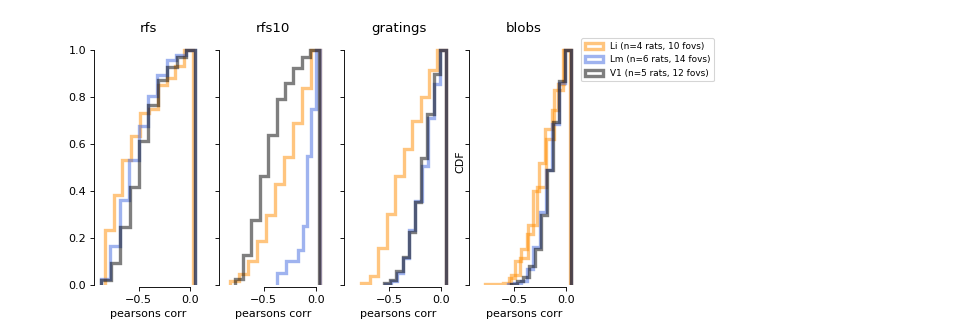

In [33]:
cdf = True
fig, axes = pl.subplots(1, 4, figsize=(12,4), sharex=True, sharey=True)
for visual_area, tmpd in df.groupby(['visual_area']):
    g = tmpd[tmpd['pval'] < 0.05]

    nrats = len(g['animalid'].unique())

    for i, (experiment, gg) in enumerate(g.groupby(['experiment'])):
        if experiment =='rfs':
            ax = axes[0]
        elif experiment == 'rfs10':
            ax = axes[1]
        elif experiment == 'gratings':
            ax = axes[2]
        elif experiment == 'blobs':
            ax = axes[3]

        values = gg['corrcoef'].values
        weights = np.ones_like(values)/float(len(values))
        
        nfovs = len(g.groupby(['animalid', 'session', 'fov']).groups)
        if i==0:
            label = '%s (n=%i rats, %i fovs)' % (visual_area, nrats, nfovs)
        else:
            label = None
        ax.hist(values, 
                cumulative=cdf,
                label=label,
                color=area_colors[visual_area],
                histtype='step', alpha=0.5, lw=3,
                normed=0, weights=weights)

        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
        ax.set_title(experiment)

        
for ax in axes:
    sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel('pearsons corr')
if cdf:
    ax.set_ylabel('CDF')
else:
    ax.set_ylabel('fraction')
    
pl.subplots_adjust(right=0.6, left=0.1, wspace=0.2)


In [72]:
both_rfs = [k for k, g in sdata.groupby(['animalid', 'session', 'fov']) \
     if 'rfs' in g['experiment'].unique() and 'rfs10' in g['experiment'].unique()]

In [73]:
both_rfs

[('JC085', '20190622', 'FOV1_zoom2p0x'),
 ('JC091', '20190602', 'FOV1_zoom2p0x'),
 ('JC097', '20190613', 'FOV1_zoom2p0x'),
 ('JC097', '20190616', 'FOV1_zoom2p0x')]

# Plot active cells per experiment type


In [27]:
corrcoef_fpath = os.path.join(aggregate_dir, 'cell-dist_v_cond-corrs_corrcoef-%s_active-cells.pkl' % corr_method)
with open(corrcoef_fpath, 'rb') as f:
    df = pkl.load(f)

<IPython.core.display.Javascript object>


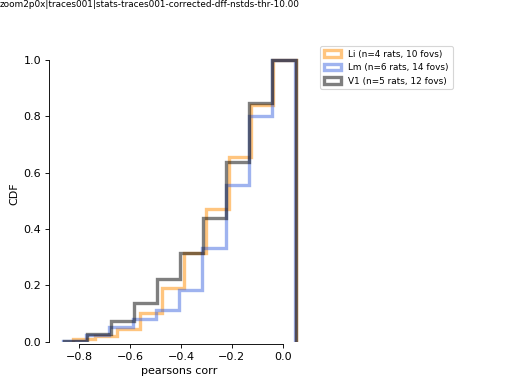

In [28]:
cdf = True
fig, ax = pl.subplots()
fig.patch.set_alpha(1)

for visual_area, tmpd in df.groupby(['visual_area']):
    g = tmpd[tmpd['pval'] < 0.05]

    nrats = len(g['animalid'].unique())
    values = g['corrcoef'].values
    weights = np.ones_like(values)/float(len(values))

    nfovs = len(g.groupby(['animalid', 'session', 'fov']).groups)
    label = '%s (n=%i rats, %i fovs)' % (visual_area, nrats, nfovs)

    ax.hist(values, 
            cumulative=cdf,
            label=label,
            color=area_colors[visual_area],
            histtype='step', alpha=0.5, lw=3,
            normed=0, weights=weights)

    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)

        
sns.despine(ax=ax, trim=True, offset=2)
ax.set_xlabel('pearsons corr')
if cdf:
    ax.set_ylabel('CDF')
else:
    ax.set_ylabel('fraction')
    
pl.subplots_adjust(right=0.6, left=0.1, wspace=0.2)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(aggregate_dir, 'corr_cell-dist_vs_trial-resp_all-experiments_active-cells-per.png'))

<IPython.core.display.Javascript object>


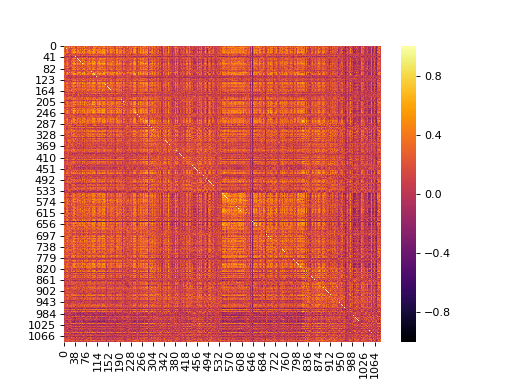

In [40]:
corr_trials = tstats.T.corr()
pl.figure()
sns.heatmap(corr_trials, cmap='inferno', vmin=-1, vmax=1)

<IPython.core.display.Javascript object>


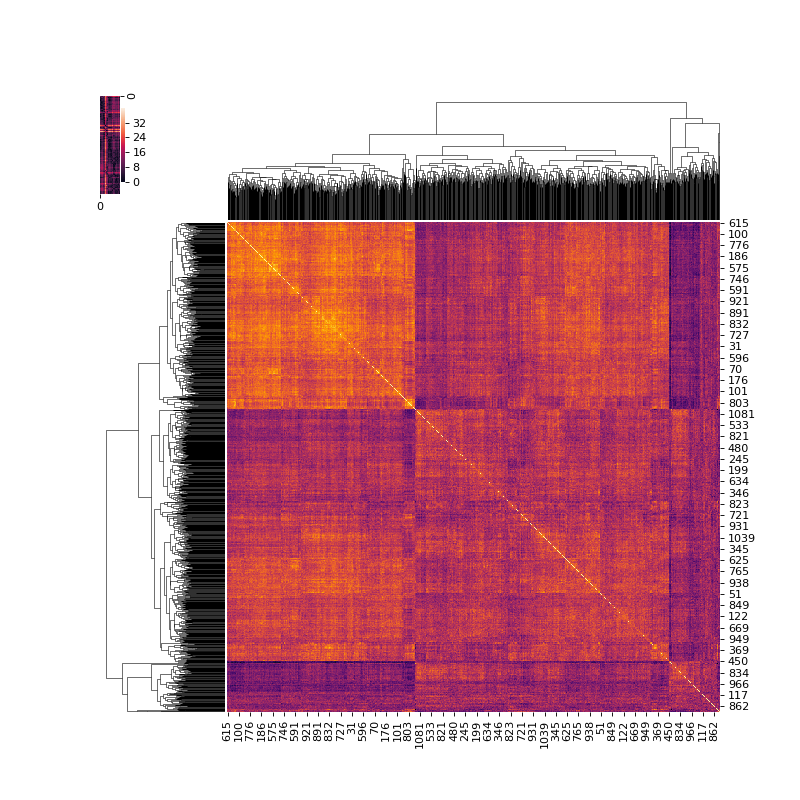

In [45]:
sns.clustermap(corr_trials, cmap='inferno', z_score=None)